# Microvilli orientation
- Visualize Anastasia's microvilli orientation data (more detailed excel sent in Aug 2020)
- Determine if microvilli twist is more or less constant in the DRA
- Determine if candidates for polarization detection have more or less orthogonally oriented microvilli in the DRA

In [11]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from typing import Tuple
import seaborn as sns
from scipy.stats import mannwhitneyu
#from sklearn.decomposition import pca

from cx_analysis.vis.hex_lattice import hexplot
from cx_analysis.vis.fig_tools import linear_cmap, subtype_cm

ImportError: cannot import name 'pca' from 'sklearn.decomposition' (/mnt/home/nchua/miniconda3/envs/wasp-lite/lib/python3.8/site-packages/sklearn/decomposition/__init__.py)

In [2]:
st_cm = subtype_cm()
# st_cm['R7'] = 'k'
# st_cm["R7'"] = 'r'
tp = '210809'
xl_dir = f'~/Data/{tp}_lamina/Raw microvilli.xlsx'
full_df = pd.read_excel(xl_dir, sheet_name='microvilli angle', header=None, index_col=None)

# Adding this to the angles make them relative to the eye's meridean (dorsal neighbor) 
offsets = pd.read_csv(f'~/Data/{tp}_lamina/microvilli-offsets.csv', header=None, index_col=0)

In [3]:
offsets.loc['C2']

1   -20.8
Name: C2, dtype: float64

In [4]:
# The excel file contains a table for each ommatidium, the formatting is very consistent
twist = []
# TODO: extract other data
om_df = []
cell_df = []
c5_offset = 0
inverted = []

for i in range(0, 29):  # ommatidia
    # excel has 16 rows for each ommatidia, but only 13 have data
    this_range = full_df.loc[i * 16 + c5_offset: i * 16 + 13 + c5_offset].reset_index(drop=True)
    this_om = this_range.iloc[0, 0]
    if this_om == 'C5':  # C5 has an extra row that replaces one of the blank ones at the end
        this_range = full_df.loc[i * 16: i * 16 + 14].reset_index(drop=True)
        rows = 11
        c5_offset += 1
    else:
        rows = 10
    # these cells contain the z-index each measurement was taken
    z_st_cols = this_range.iloc[3, 13:]  
    
    

    assert(len(this_om) == 2)  # check om name
    assert(len(z_st_cols) == 9)  # check that there are 9 photoreceptors

    for ii, this_st in this_range.iloc[0, 4:13].items():  # subtypes 
        if '(' in this_st:  # some have the old subtype nomenclature in ()
            this_st = this_st.split('(')[0]
        this_st = this_st.strip().upper()
#         if this_st == "R7'":
#             this_st = 'R7p'
        z_col = z_st_cols[z_st_cols == this_st.lower()].index[0]
        
        # Add negative sign to indices of stacks that start proximal so the direction is distal->proximal
        if this_range.iloc[2, 4] < this_range.iloc[3, 4]: # start/end index for R1
            z_inds = this_range.iloc[4:, z_col]
        else:
            z_inds = this_range.iloc[4:, z_col] * -1.0
            inverted.append(this_om)
            #this_range.iloc[4:, ii] = this_range.iloc[4:, ii] * -1.0
        these_angles = this_range.iloc[4:, ii] + offsets.loc[this_om, 1]
        twist.append(pd.DataFrame({'om': [this_om]*rows, 
                                     'subtype': [this_st]*rows, 
                                     'z-index': z_inds, 
                                     'angle': these_angles}))
        
twist_df = pd.concat(twist, ignore_index=True)
twist_df = twist_df.astype({'z-index': float, # because there are NaNs
                           'angle': float})
twist_df = twist_df.sort_values(by=['om', 'subtype', 'z-index'])

### Only count first 5 slices ###
#twist_df = twist_df.iloc[]
for om in inverted:
    twist_df.loc[twist_df.om == om, 'angle'] = twist_df.loc[twist_df.om == om, 'angle'] * -1.0

display(twist_df)
display(twist_df.subtype.unique())
display(twist_df.describe())


om subtype  z-index  angle
630  A0      R1  -3255.0   17.1
631  A0      R1  -3102.0    3.5
632  A0      R1  -2949.0   14.3
633  A0      R1  -2796.0  -13.4
634  A0      R1  -2643.0  -18.7
..   ..     ...      ...    ...
535  E7      R8   2397.0   77.4
536  E7      R8   2469.0   63.4
537  E7      R8   2541.0   63.4
538  E7      R8   2613.0   71.8
539  E7      R8   2685.0   71.8

[2619 rows x 4 columns]

array(['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', "R7'", 'R8'],
      dtype=object)

z-index        angle
count  2611.000000  2598.000000
mean  -1091.582535    25.504196
std    1701.657722   114.216440
min   -3343.000000  -218.500000
25%   -2291.000000   -50.250000
50%   -1763.000000    20.150000
75%    -914.000000   111.800000
max    2967.000000   329.700000

In [5]:
def convert_angle(angles: pd.Series) -> pd.Series:
    #angles = pd.Series([a if a >= 0 else 360 + a for a in angles.tolist()], index=angles.index)
    
    angles = angles % 180
    #angles = np.arccos(np.sin(np.radians(angles)))
    angles = np.radians(angles) 
    return angles

def sin_angle(angles: pd.Series) -> pd.Series:
    #angles = pd.Series([a if a >= 0 else 180 + a for a in angles.tolist()], index=angles.index)
    angles = angles % 180.0
    angles = np.sin(np.radians(angles))
    return angles

test_angles = [-170.0, 170.0, -10, 10]
display(convert_angle(pd.Series(test_angles)))

twist_df.loc[:, 'conv-angle'] = convert_angle(twist_df.angle)
twist_df.loc[:, 'sin-angle'] = sin_angle(twist_df.angle)
display(twist_df.describe())

#twist_df.to_csv(f'~/Data/{tp}_lamina/microvilli-angle-conv.csv')

0    0.174533
1    2.967060
2    2.967060
3    0.174533
dtype: float64

z-index        angle   conv-angle    sin-angle
count  2611.000000  2598.000000  2598.000000  2598.000000
mean  -1091.582535    25.504196     1.612044     0.539975
std    1701.657722   114.216440     1.029100     0.338424
min   -3343.000000  -218.500000     0.000000     0.000000
25%   -2291.000000   -50.250000     0.674133     0.223250
50%   -1763.000000    20.150000     1.494875     0.532137
75%    -914.000000   111.800000     2.708751     0.901454
max    2967.000000   329.700000     3.138102     1.000000

In [7]:
def circular_hist(ax, x, bins=32, density=True, offset=0, gaps=True, 
                  color='k'):
    """
    Produce a circular histogram of angles on ax.
    From Stackoverflow user: jwalton
    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor=color, fill=False, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [8]:
all_om = sorted(twist_df['om'].unique())
dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']  # as defined by connectivity clustering
ndra_om = [str(o) for o in all_om if o not in dra_om]
subtypes = sorted(twist_df['subtype'].unique())

In [9]:
def om_subplot_position(om: str) -> Tuple:
    
    return 4 - (ord(om[0]) - 65), 7-int(om[1])
om_subplot_position('E0')


(0, 7)

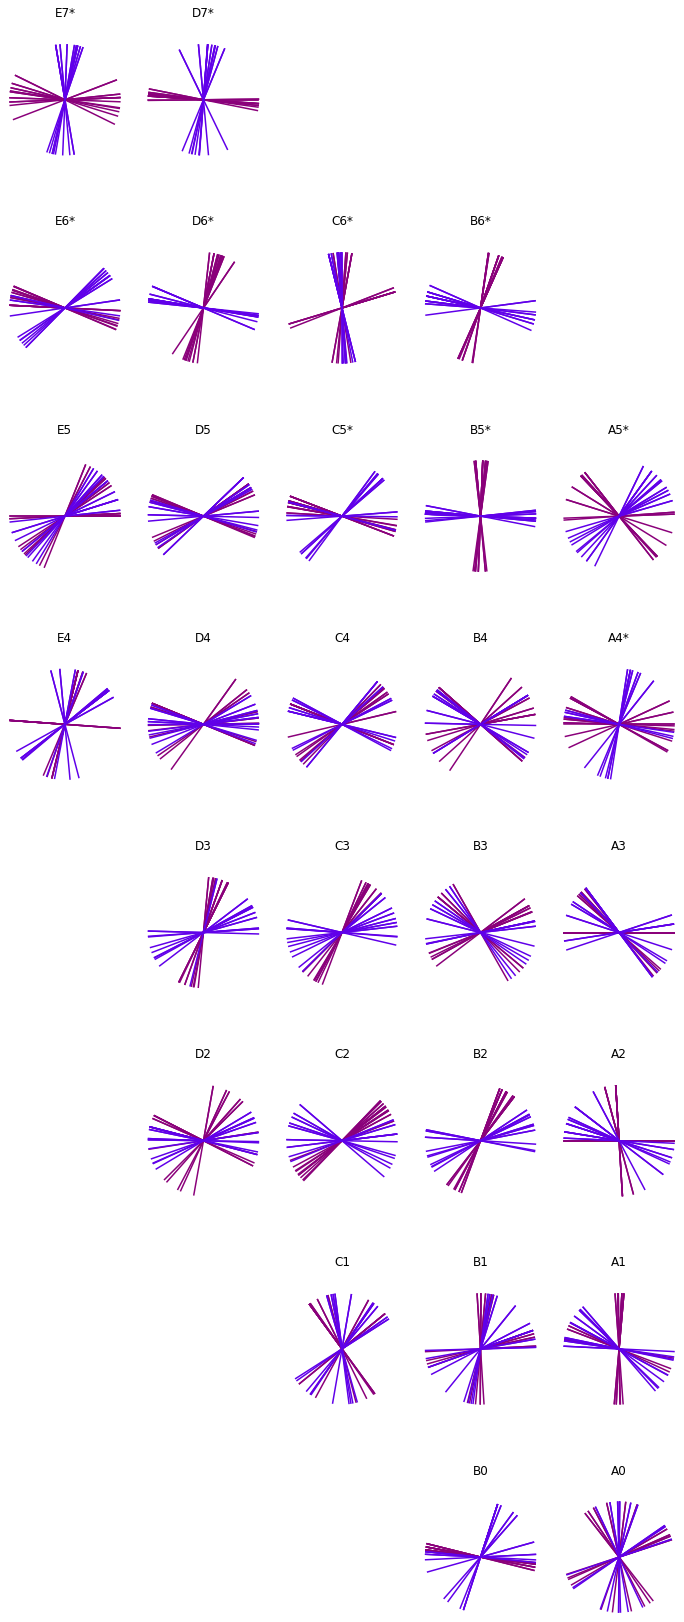

In [15]:
fig, axes = plt.subplots(8, 5, figsize=[12, 30], subplot_kw={'projection': 'polar'})


# rt_radius = {'R7': 0.9, 
#              "R7'": 1.0}

#axes = ax.flatten()
f_i = 0
for om, v in twist_df.groupby('om'):
    row, col = om_subplot_position(om)
    ax = axes[col, row]
    
    means = []
    medians = []
    for rt, vv in v.groupby('subtype'):
        if rt not in ['R7', "R7'"]:#, "R8"]:
            continue
            
        c = st_cm[rt]
        
        mn = vv['conv-angle'].mean()
        md = vv['conv-angle'].median()
        #ax.plot([np.pi + md, 0], [16, 0], lw=2, ls='--', c=c)
        
        medians.append(md)
        means.append(mn)
        #ax.plot([np.pi + mn_angle, 0, md_angle], [16, 0, 16], lw=2, ls='--', c=c)
        z=0
        
        
        for i, vvv in vv['conv-angle'].items():
            radius = 15.0 #- (z * 1.0)
            ax.plot([np.pi + vvv, 0, vvv], [radius, 0, radius], c=c)
            z += 1.0
            ax.plot([0, vvv], [0, radius], c=c, label=rt)
        
    if om in dra_om:
        ax.set_title(om + '*') #+ f"\n$\Delta$ median ={abs(medians[0] - medians[1]): .2f}" 
                    #+ f"\n$\Delta$ mean={abs(means[0] - means[1]): .2f}")
    else: 
        ax.set_title(om) #+ f"\n$\Delta$ median={abs(medians[0] - medians[1]): .2f}"
                     #+ f"\n$\Delta$ mean={abs(means[0] - means[1]): .2f}")
    

#axes[0, 1].legend()

for ax in axes.flatten():
    ax.axis('off')
#fig.delaxes(axes[-1])

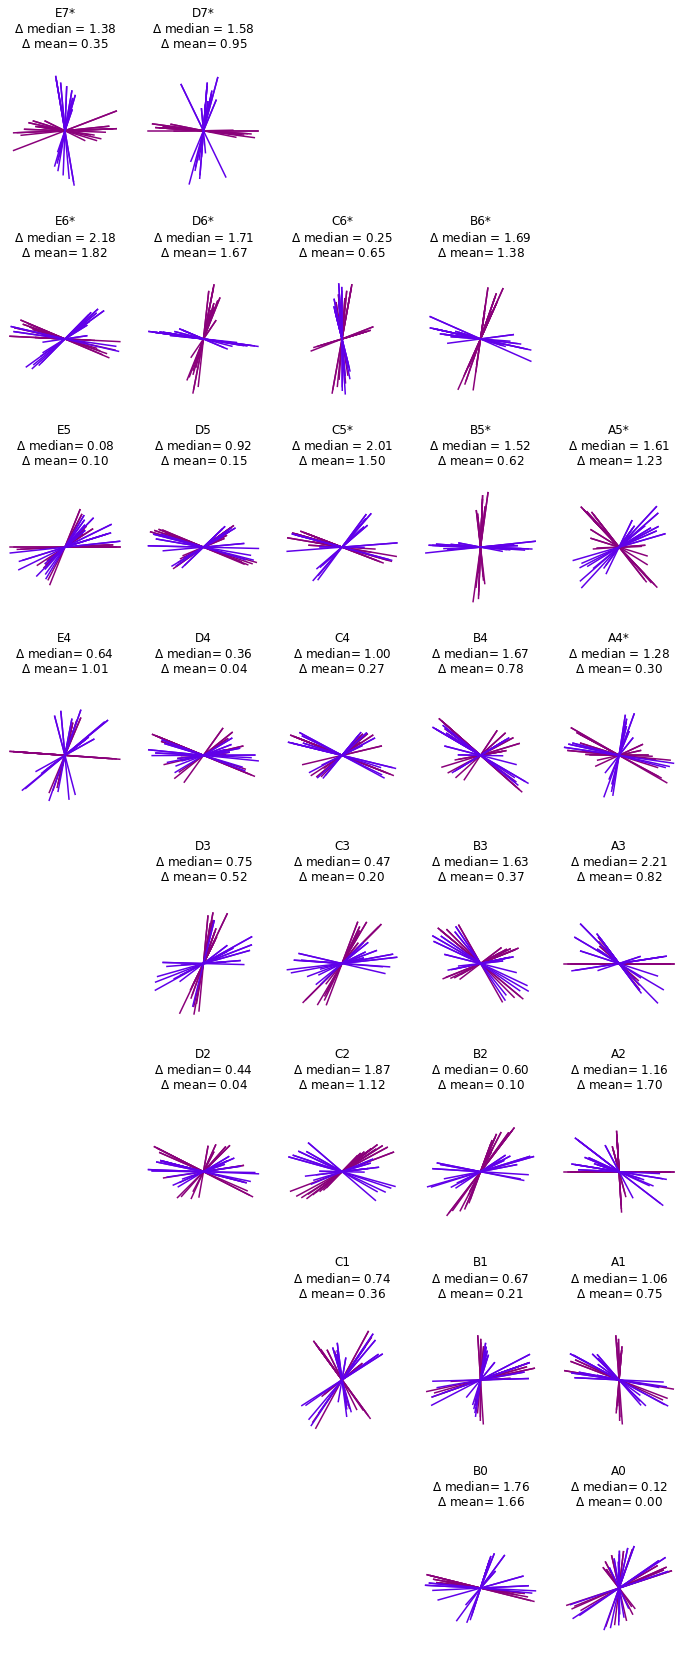

In [12]:
fig, axes = plt.subplots(8, 5, figsize=[12, 30], subplot_kw={'projection': 'polar'})


# rt_radius = {'R7': 0.9, 
#              "R7'": 1.0}

#axes = ax.flatten()
f_i = 0
for om, v in twist_df.groupby('om'):
    row, col = om_subplot_position(om)
    ax = axes[col, row]
    
    means = []
    medians = []
    for rt, vv in v.groupby('subtype'):
        if rt not in ['R7', "R7'"]:#, "R8"]:
            continue
            
        c = st_cm[rt]
        
        mn = vv['conv-angle'].mean()
        md = vv['conv-angle'].median()
        #ax.plot([np.pi + md, 0], [16, 0], lw=2, ls='--', c=c)
        
        medians.append(md)
        means.append(mn)
        #ax.plot([np.pi + mn_angle, 0, md_angle], [16, 0, 16], lw=2, ls='--', c=c)
        z=0
        
        
        for i, vvv in vv['conv-angle'].items():
            radius = 15.0 - (z * 1.0)
            ax.plot([np.pi + vvv, 0, vvv], [radius, 0, radius], c=c)
            z += 1.0
            ax.plot([0, vvv], [0, radius], c=c, label=rt)
        
    if om in dra_om:
        ax.set_title(om + '*' + f"\n$\Delta$ median ={abs(medians[0] - medians[1]): .2f}" 
                    + f"\n$\Delta$ mean={abs(means[0] - means[1]): .2f}")
    else: 
        ax.set_title(om + f"\n$\Delta$ median={abs(medians[0] - medians[1]): .2f}"
                     + f"\n$\Delta$ mean={abs(means[0] - means[1]): .2f}")
    

#axes[0, 1].legend()

for ax in axes.flatten():
    ax.axis('off')
#fig.delaxes(axes[-1])

NameError: name 'pca' is not defined

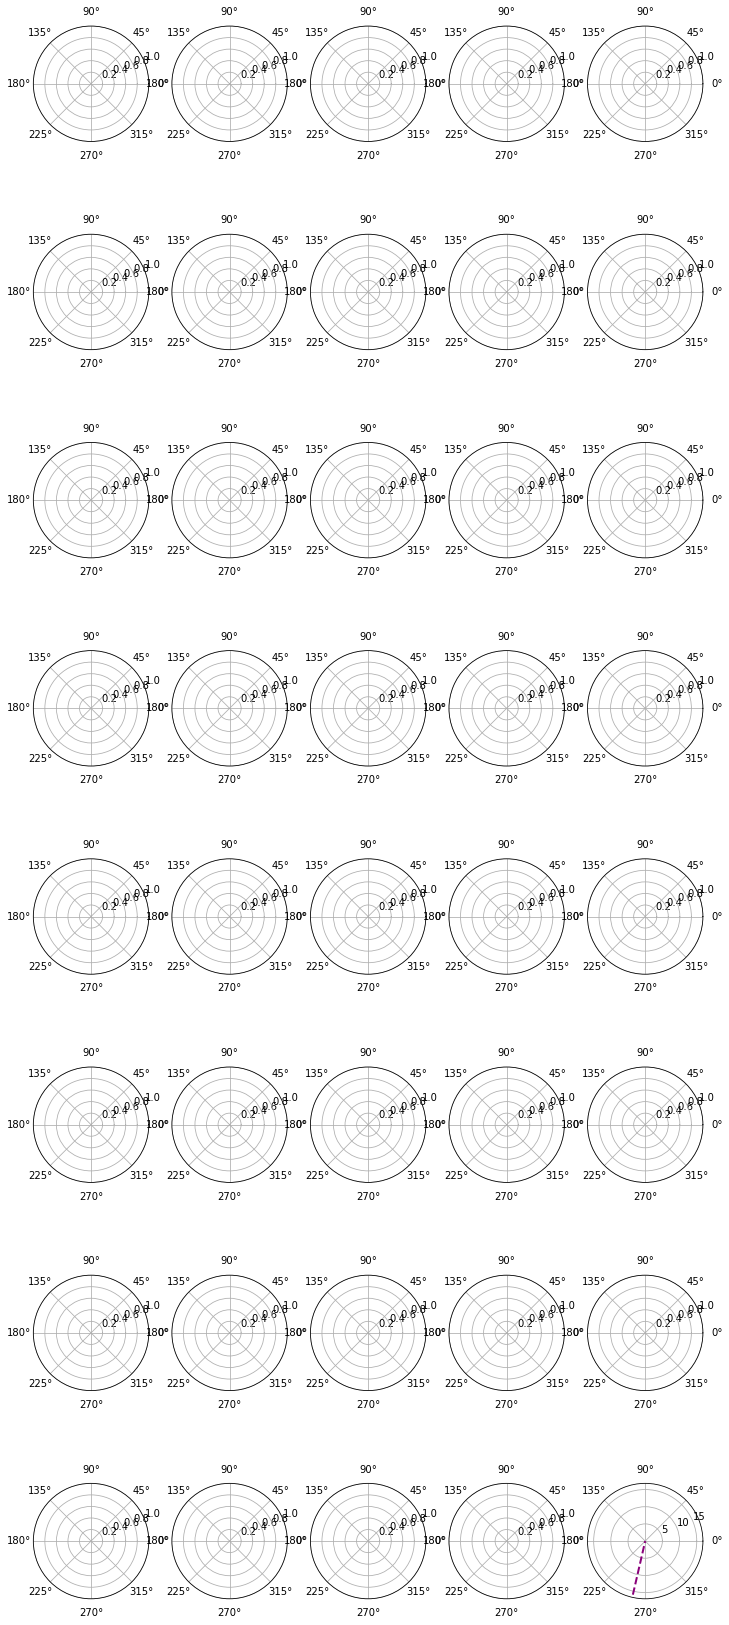

In [13]:
fig, axes = plt.subplots(8, 5, figsize=[12, 30], subplot_kw={'projection': 'polar'})


f_i = 0
for om, v in twist_df.groupby('om'):
    row, col = om_subplot_position(om)
    ax = axes[col, row]
    
    means = []
    medians = []
    for rt, vv in v.groupby('subtype'):
        if rt not in ['R7', "R7'"]:#, "R8"]:
            continue
            
        c = st_cm[rt]
        
        mn = vv['conv-angle'].mean()
        md = vv['conv-angle'].median()
        ax.plot([np.pi + md, 0], [16, 0], lw=2, ls='--', c=c)
        
        medians.append(md)
        means.append(mn)
        #ax.plot([np.pi + mn_angle, 0, md_angle], [16, 0, 16], lw=2, ls='--', c=c)
        z=0
        
        points = np.cos(vv['conv-angle'])
        pca
        
        for i, vvv in vv['conv-angle'].items():
            radius = 15.0 #- (z * 1.0)
            #ax.plot([np.pi + vvv, 0, vvv], [radius, 0, radius], c=c)
            z += 1.0
            ax.plot([0, vvv], [0, radius], c=c, label=rt)
        
    if om in dra_om:
        ax.set_title(om + '*' + f"\n$\Delta$ median ={abs(medians[0] - medians[1]): .2f}" 
                    + f"\n$\Delta$ mean={abs(means[0] - means[1]): .2f}")
    else: 
        ax.set_title(om + f"\n$\Delta$ median={abs(medians[0] - medians[1]): .2f}"
                     + f"\n$\Delta$ mean={abs(means[0] - means[1]): .2f}")
    

#axes[0, 1].legend()

for ax in axes.flatten():
    ax.axis('off')
#fig.delaxes(axes[-1])

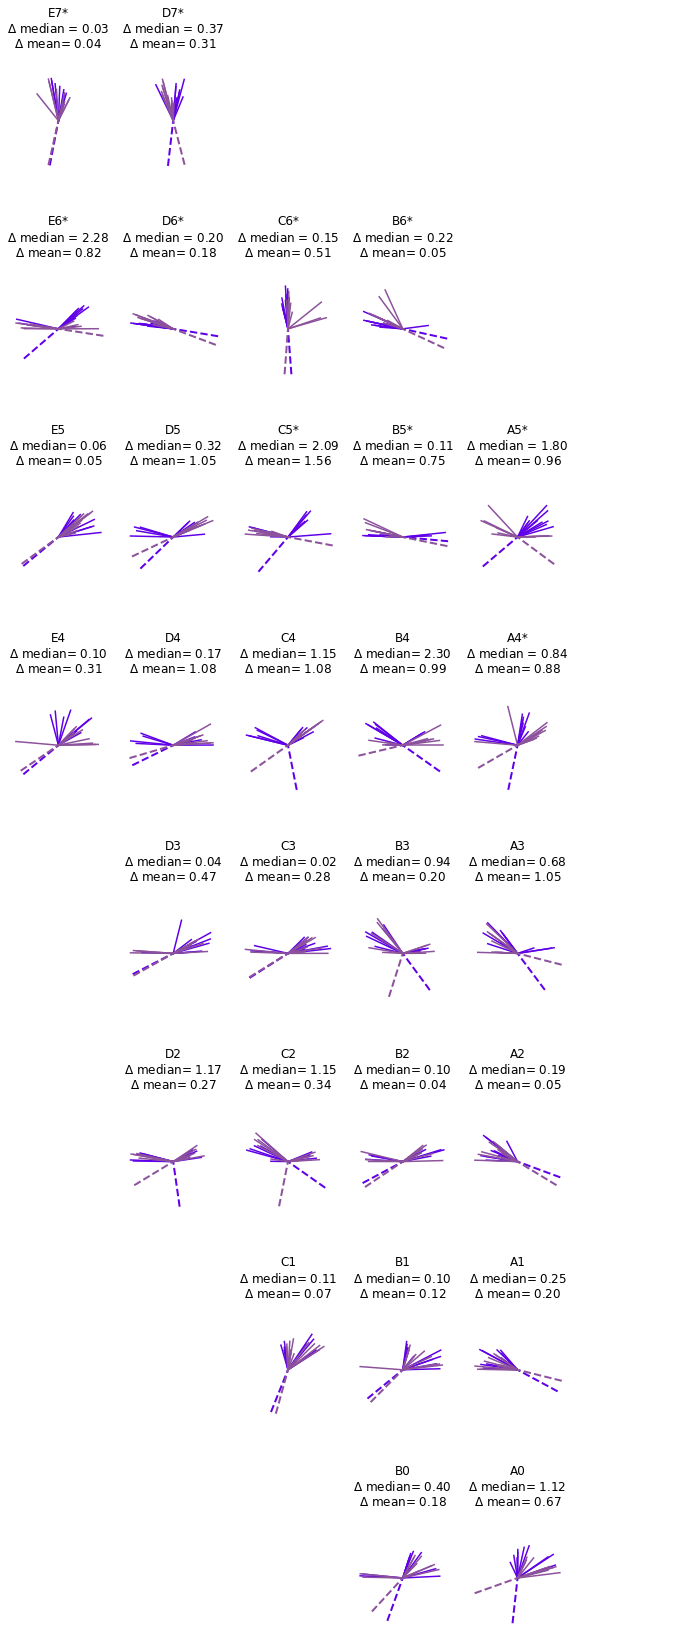

In [20]:
fig, axes = plt.subplots(8, 6, figsize=[12, 30], subplot_kw={'projection': 'polar'})

# rt_radius = {'R7': 0.9, 
#              "R7'": 1.0}

#axes = ax.flatten()
f_i = 0
for om, v in twist_df.groupby('om'):
    row, col = om_subplot_position(om)
    ax = axes[col, row]
    
    means = []
    medians = []
    for rt, vv in v.groupby('subtype'):
        if rt not in ['R8', "R7'"]:#, "R8"]:
            continue
            
        c = st_cm[rt]
        
        mn = vv['conv-angle'].mean()
        md = vv['conv-angle'].median()
        ax.plot([np.pi + md, 0], [16, 0], lw=2, ls='--', c=c)
        
        medians.append(md)
        means.append(mn)
        #ax.plot([np.pi + mn_angle, 0, md_angle], [16, 0, 16], lw=2, ls='--', c=c)
        z=0

        for i, vvv in vv['conv-angle'].items():
            radius = 15.0 - (z * 1.0)
            #ax.plot([np.pi + vvv, 0, vvv], [radius, 0, radius], c=c)
            z += 1.0
            ax.plot([0, vvv], [0, radius], c=c, label=rt)
        
    if om in dra_om:
        ax.set_title(om + '*' + f"\n$\Delta$ median ={abs(medians[0] - medians[1]): .2f}" 
                    + f"\n$\Delta$ mean={abs(means[0] - means[1]): .2f}")
    else: 
        ax.set_title(om + f"\n$\Delta$ median={abs(medians[0] - medians[1]): .2f}"
                     + f"\n$\Delta$ mean={abs(means[0] - means[1]): .2f}")
    

#axes[0, 0].legend()

for ax in axes.flatten():
    ax.axis('off')
#fig.delaxes(axes[-1])

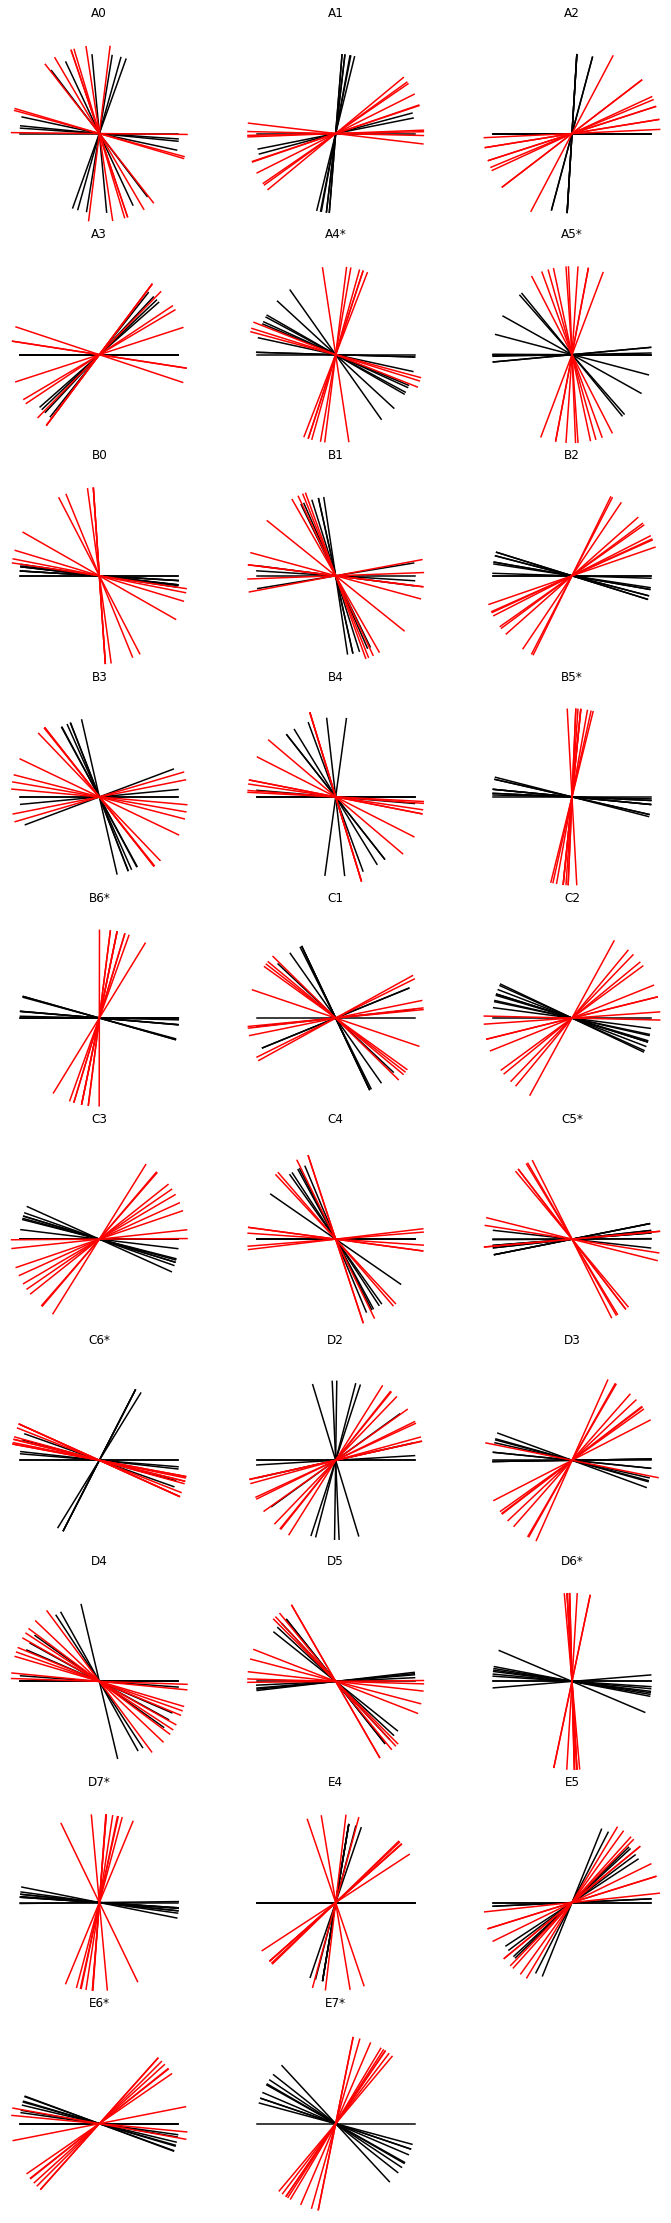

In [10]:
fig, ax = plt.subplots(10, 3, figsize=[12, 40], subplot_kw={'projection': 'polar'})

rt_radius = {'R7': 0.9, 
             "R7'": 1.0}

axes = ax.flatten()
f_i = 0
for om, v in twist_df.groupby('om'):
    
    for rt, vv in v.groupby('subtype'):
        if rt not in ['R7', "R7'"]:#, "R8"]:
            continue
            
        c = st_cm[rt]
        if om in dra_om:
            axes[f_i].set_title(om + '*')
        else: 
            axes[f_i].set_title(om)
        for i, vvv in vv['conv-angle'].items():
            axes[f_i].plot([np.pi + vvv, 0, vvv], [rt_radius[rt], 0, rt_radius[rt]], c=c)
            #axes[f_i].plot([0, vvv], [0, rt_radius[rt]], c=c)
            #print(f"{i} {rt} {om} {vvv}")
    axes[f_i].axis('off') 
    f_i += 1
    
fig.delaxes(axes[-1])

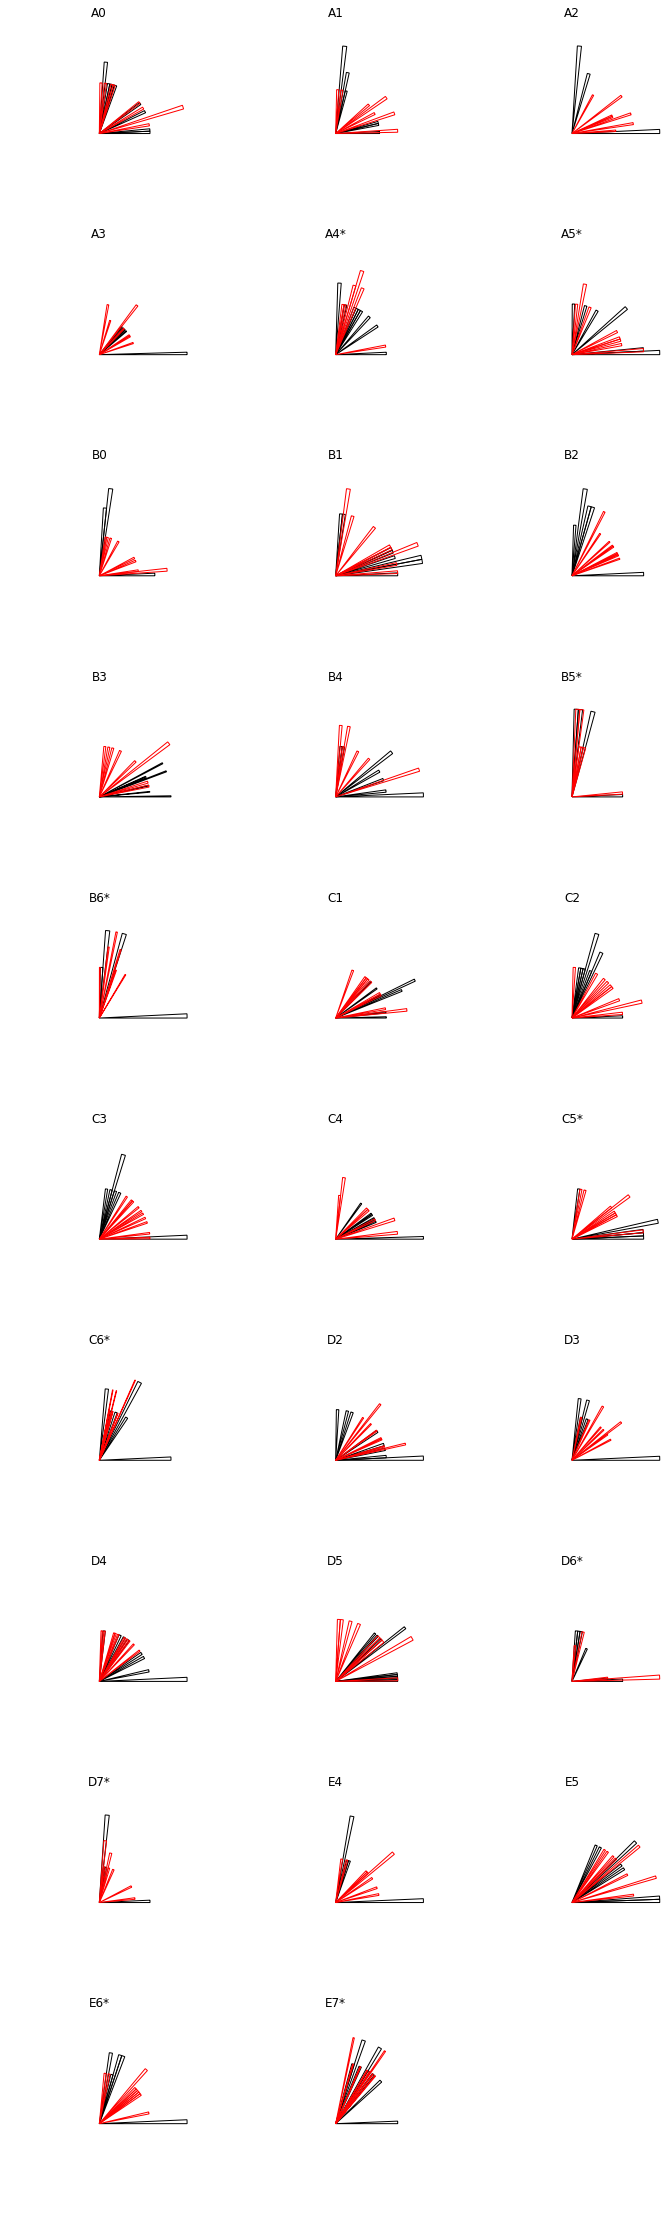

In [82]:
fig, ax = plt.subplots(10, 3, figsize=[12, 40], subplot_kw={'projection': 'polar'})



axes = ax.flatten()
f_i = 0
for om, v in twist_df.groupby('om'):
    
    for rt, vv in v.groupby('subtype'):
        if rt not in ['R7', "R7'"]:#, "R8"]:
            continue
            
        c = st_cm[rt]
        if om in dra_om:
            axes[f_i].set_title(om + '*')
        else: 
            axes[f_i].set_title(om)

        circular_hist(axes[f_i], vv['conv-angle'].dropna().to_numpy(), color=c)
        
    axes[f_i].axis('off') 
    f_i += 1
    
fig.delaxes(axes[-1])

In [ ]:
all_om = sorted(twist_df['om'].unique())
dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']  # as defined by connectivity clustering
ndra_om = [str(o) for o in all_om if o not in dra_om]
subtypes = sorted(twist_df['subtype'].unique())

## Compute angular differences between measurements
- Data is collected on ImageJ, which records the smaller (< 180) angle between two lines drawn by the user
- Anastasia added a negative sign to angles measured clockwise from the reference angle
- Because of this, we cannot use angle1 - angle2 as the difference
- First, the angle1 - angle2 differences are converted into minimal positive (counter-clockwise) angles by taking % 360 , "_diff"
- Secondly, for counter clockwise angles more than +180, we take the smaller angle in the CCW direction by subtracting 360, "diff". This retains the sign convention of negative -> CW twist 

In [ ]:


for i, om_rows in twist_df.groupby('om'):
    for ii, rows in om_rows.groupby('subtype'):
        n = 0
        for iii, row in rows.sort_values('z-index').iterrows():
            twist_df.loc[iii, 'n'] = int(n)
            if n == 0:  # first measurement has diff of 0
                twist_df.loc[iii, '_diff'] = np.nan
                twist_df.loc[iii, 'diff'] = np.nan
                twist_df.loc[iii, 'cumulative'] = 0.0
                twist_df.loc[iii, '_angle'] = twist_df.loc[iii, 'angle']
                twist_df.loc[iii, 'interval_len'] = np.nan # 0.0
                twist_df.loc[iii, 'interval_z'] = np.nan
                previous = (iii, twist_df.loc[iii, 'angle'])
            elif math.isnan(twist_df.loc[iii, 'angle']):
                #print(f"NaN found for {i}_{ii} measurement: {n}")
                twist_df.loc[iii, '_diff'] = np.nan
                twist_df.loc[iii, 'diff'] = np.nan
                twist_df.loc[iii, 'cumulative'] = np.nan
                twist_df.loc[iii, '_angle'] = np.nan
                twist_df.loc[iii, 'interval_len'] = np.nan
                twist_df.loc[iii, 'interval_z'] = np.nan
                # previous = measurement before the NaN, though n still increases by 1
            else:
                twist_df.loc[iii, '_diff'] = (twist_df.loc[iii, 'angle'] - previous[1]) % 360.0
                twist_df.loc[iii, 'diff'] = twist_df.loc[iii, '_diff'] - 360.0 * (twist_df.loc[iii, '_diff'] > 180.0)
                twist_df.loc[iii, 'cumulative'] = twist_df.loc[previous[0], 'cumulative'] + twist_df.loc[iii, 'diff']
                twist_df.loc[iii, '_angle'] = twist_df.loc[previous[0], '_angle'] + twist_df.loc[iii, 'diff']
                twist_df.loc[iii, 'interval_len'] = (twist_df.loc[iii, 'z-index'] - twist_df.loc[previous[0], 'z-index']) * 8.0 / 1000.0
                twist_df.loc[iii, 'interval_z'] = twist_df.loc[iii, 'z-index'] - twist_df.loc[previous[0], 'z-index']
                # because 1 px = 8/1000 microns
                previous = (iii, twist_df.loc[iii, 'angle'])
            n += 1
twist_df['diff_per_micron'] = twist_df['diff'] / twist_df['interval_len']
#twist_df['_angle'] = twist_df['_angle'] % 180.0
            
#twist_df['diff'] = twist_df['_diff'] - 360*(twist_df['_diff']>180)

# display(twist_df.loc[(twist_df['om']=='A0') & (twist_df['subtype'] == 'R5'), 
#                     ('om', 'subtype', 'z-index', 'angle', '_diff', 'diff', 'cumulative')].sort_values('z-index'))

# Example D6_R1 shows how NaNs are used 
display(twist_df.loc[(twist_df['om']=='D6') & (twist_df['subtype'] == 'R1'), :].sort_values('z-index'))
display(twist_df.loc[(twist_df['om']=='A4') & (twist_df['subtype'] == 'R8'), :].sort_values('z-index'))
display(twist_df.loc[(twist_df['om']=='B1') & (twist_df['subtype'] == 'R7'), :].sort_values('z-index'))

display(twist_df.loc[:, 'cumulative'].max())
display(twist_df.loc[:, 'diff'].max())

## 

In [6]:
#twist_df['cosine'] = np.cos(twist_df['angle']*(np.pi/180.0))
twist_df['cosine_sq'] = np.cos(twist_df['angle']*(np.pi/180.0)) ** 2
twist_df['CCW_angle'] = [(360.0 + x) if x < 0 else x for x in twist_df['angle']]

In [7]:
# fig, ax = plt.subplots(15, 2, figsize=[25, 80], sharey=True)
# axes = ax.flatten()
# i = 0
# for om, rows in twist_df.groupby('om'):
    
#     #display(rows)
#     sns.lineplot(x='z-index', y='cosine_sq', hue='subtype', data=rows, markers=True, ax=axes[i])
#     axes[i].set_title(f"Ommatidium: {om}")
#     i += 1
    
# axes[-1].remove()
# #fig.savefig("/mnt/home/nchua/Dropbox/200902_microvilli_raw_all.pdf", bbox_inches='tight')

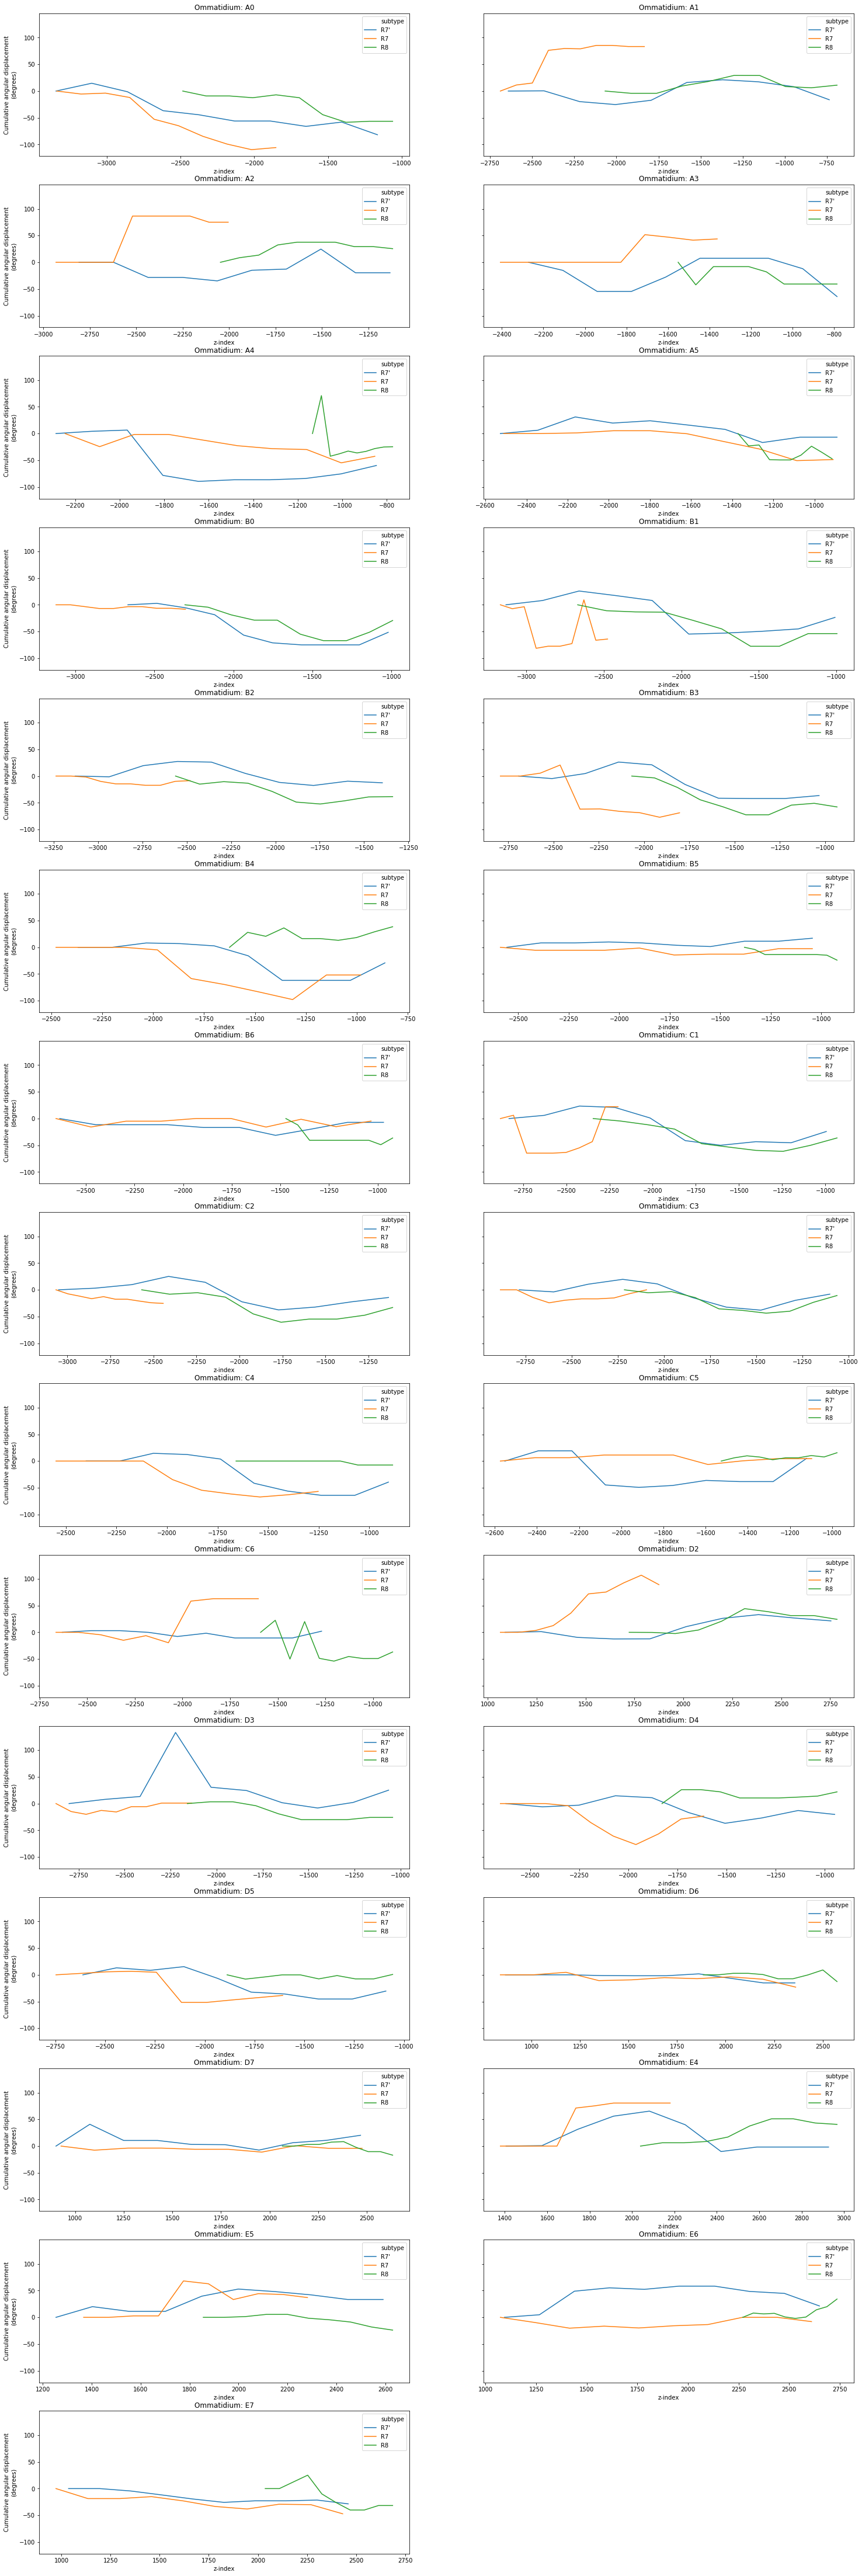

In [8]:
fig, ax = plt.subplots(15, 2, figsize=[25, 80], sharey=True)
axes = ax.flatten()
i = 0
for om, rows in twist_df.groupby('om'):
    rows = rows.loc[[i for i, v in rows['subtype'].items() if int(v[1]) > 6]] 
    #display(rows)
    sns.lineplot(x='z-index', y='cumulative', hue='subtype', data=rows, markers=True, ax=axes[i])
    axes[i].set_title(f"Ommatidium: {om}")
    axes[i].set_ylabel("Cumulative angular displacement\n(degrees)")
    i += 1
    
axes[-1].remove()
#fig.savefig("/mnt/home/nchua/Dropbox/200902_microvilli_raw_lvf.pdf", bbox_inches='tight')

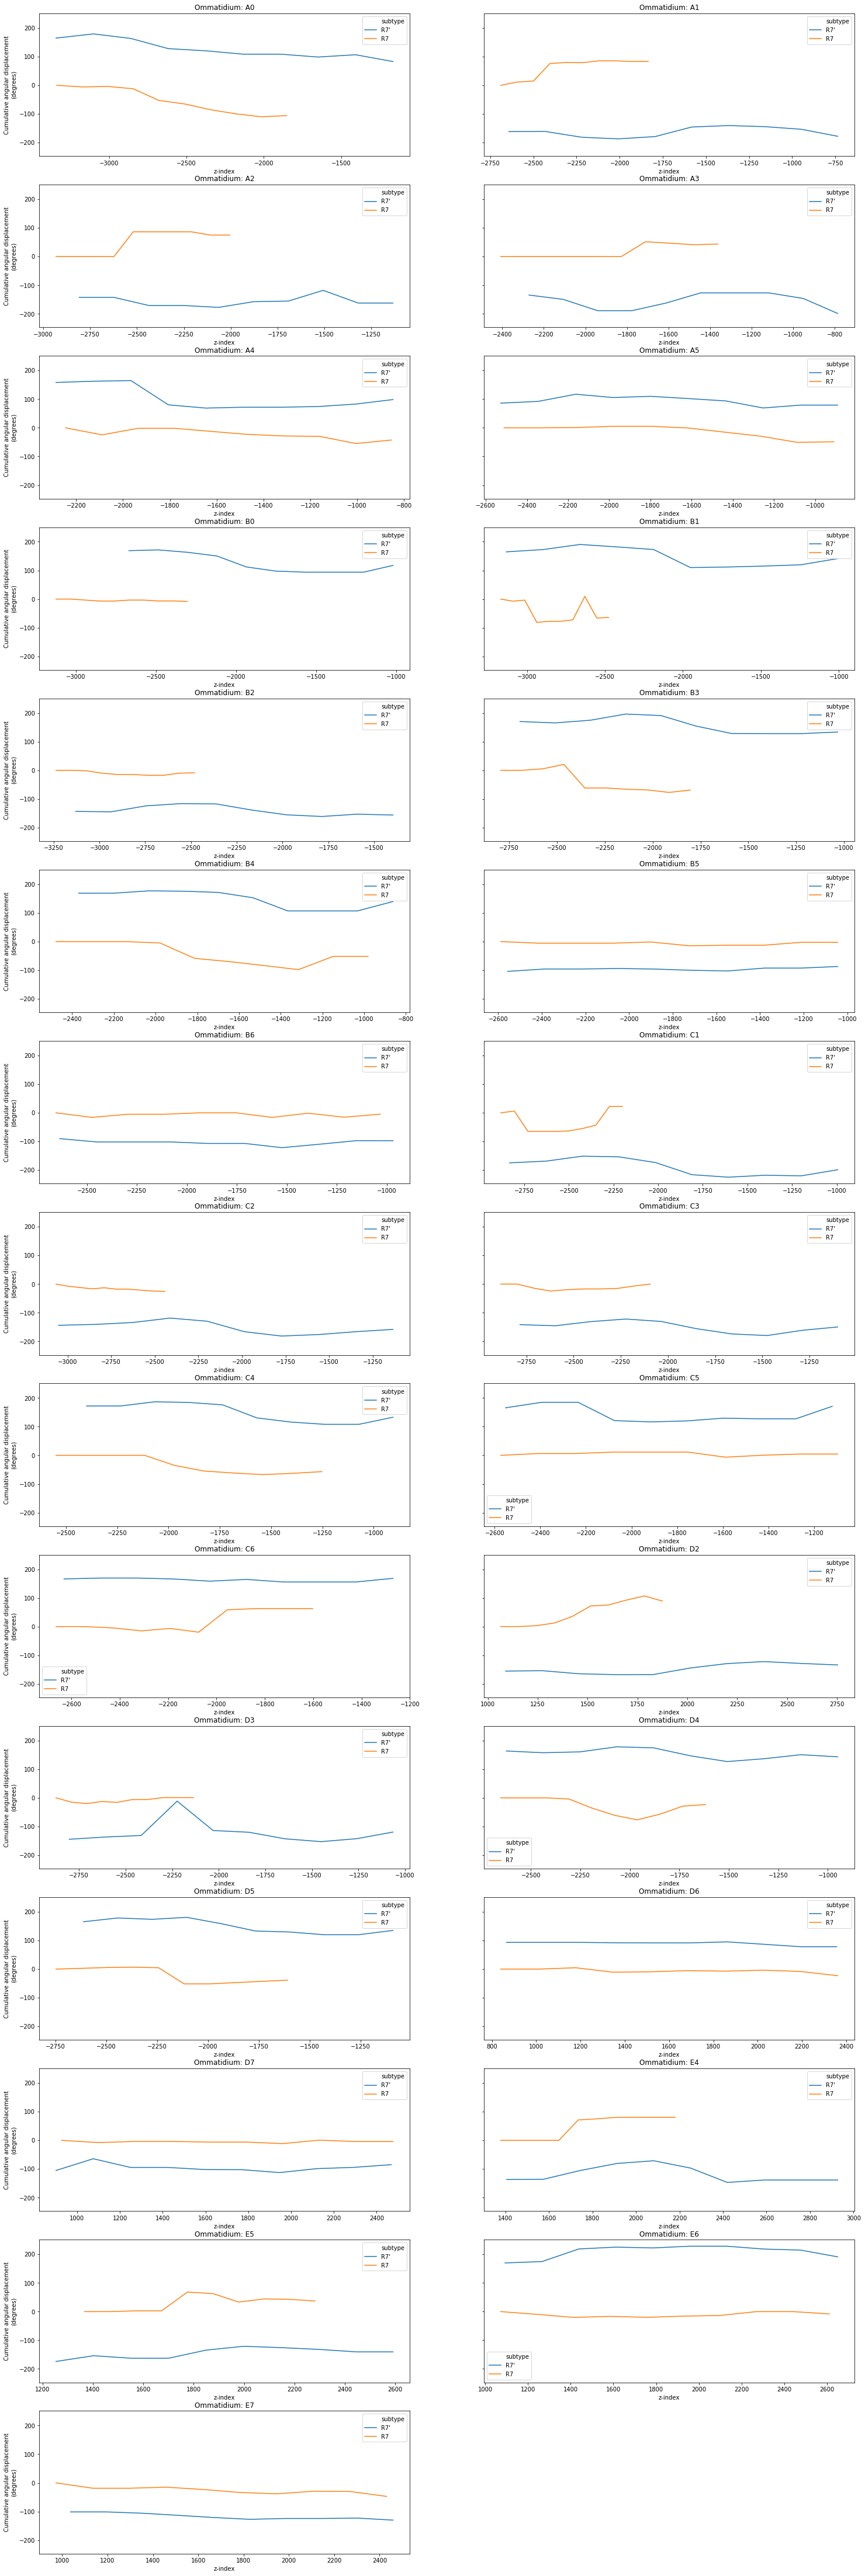

In [9]:
fig, ax = plt.subplots(15, 2, figsize=[25, 80], sharey=True)
axes = ax.flatten()
i = 0
for om, rows in twist_df.groupby('om'):
    rows = rows.loc[[i for i, v in rows['subtype'].items() if int(v[1]) == 7]] 
    #display(rows)
    sns.lineplot(x='z-index', y='_angle', hue='subtype', data=rows, markers=True, ax=axes[i])
    #sns.lineplot(x='z-index', y=)
    axes[i].set_title(f"Ommatidium: {om}")
    axes[i].set_ylabel("Cumulative angular displacement\n(degrees)")
    i += 1
    
axes[-1].remove()
#fig.savefig("/mnt/home/nchua/Dropbox/200902_microvilli_raw_lvf.pdf", bbox_inches='tight')

In [10]:
abs_diff = twist_df.copy()
#abs_diff['diff'] = np.abs(abs_diff['diff'])
abs_diff['abs_diff_per_micron'] = np.abs(abs_diff['diff_per_micron'])
abs_diff['previous_z'] = abs_diff['z-index'] - abs_diff['interval_z']

display(abs_diff['abs_diff_per_micron'].median())

5.2721088435374055

In [11]:
abs_diff.sort_values('abs_diff_per_micron', ascending=False).loc[abs_diff['subtype']=='R7', 
                    ['om', 'subtype','previous_z', 'z-index', 'diff', 'diff_per_micron']].head(20)

om subtype  previous_z  z-index  diff  diff_per_micron
2336  B1      R7     -2706.0  -2629.0  81.9       132.954545
2332  B1      R7     -3014.0  -2937.0 -77.8      -126.298701
2337  B1      R7     -2629.0  -2552.0 -75.6      -122.727273
2241  C1      R7     -2805.0  -2729.0 -70.9      -116.611842
2247  C1      R7     -2349.0  -2273.0  65.4       107.565789
165   A2      R7     -2623.0  -2520.0  86.5       104.975728
344   E4      R7      1646.0   1735.0  71.2       100.000000
1334  B3      R7     -2464.0  -2354.0 -82.5       -93.750000
1156  C6      R7     -2074.0  -1956.0  77.9        82.521186
2422  A1      R7     -2499.0  -2404.0  61.2        80.526316
2153  E5      R7      1673.0   1775.0  65.4        80.147059
1875  D5      R7     -2243.0  -2117.0 -56.4       -55.952381
253   A3      R7     -1827.0  -1711.0  51.7        55.711207
795   D2      R7      1425.0   1515.0  36.0        50.000000
1244  B4      R7     -1979.0  -1813.0 -53.7       -40.436747
2155  E5      R7      1877.0   1979.0 -29.5       -36.151961
1248  B4      R7     -1315.0  -1149.0  46.0        34.638554
1064  D4      R7     -2307.0  -2192.0 -31.4       -34.130435
794   D2      R7      1335.0   1425.0  23.3        32.361111
704   A0      R7     -2843.0  -2678.0 -40.7       -30.833333

In [12]:
abs_diff.sort_values('abs_diff_per_micron', ascending=False).loc[abs_diff['subtype']=="R7'", 
                    ['om', 'subtype','previous_z', 'z-index', 'diff', 'diff_per_micron']].head(20)

om subtype  previous_z  z-index   diff  diff_per_micron
1473  D3     R7'     -2416.0  -2223.0  119.9        77.655440
1474  D3     R7'     -2223.0  -2030.0 -102.6       -66.450777
2472  A4     R7'     -1966.0  -1806.0  -84.8       -66.250000
1926  C5     R7'     -2234.0  -2075.0  -63.9       -50.235849
210   A3     R7'      -951.0   -786.0  -52.1       -39.469697
306   E4     R7'      2251.0   2420.0  -50.1       -37.056213
1206  B4     R7'     -1533.0  -1366.0  -46.0       -34.431138
1932  C5     R7'     -1280.0  -1121.0   43.5        34.198113
34    C4     R7'     -1736.0  -1570.0  -45.3       -34.111446
2294  B1     R7'     -2188.0  -1952.0  -62.9       -33.315678
1652  E6     R7'      1266.0   1439.0   44.1        31.864162
217   A3     R7'     -2106.0  -1941.0  -39.4       -29.848485
121   A2     R7'     -1506.0  -1320.0  -44.3       -29.771505
391   D7     R7'       902.0   1076.0   40.8        29.310345
214   A3     R7'     -1611.0  -1446.0   35.2        26.666667
575   B0     R7'     -2119.0  -1936.0  -38.1       -26.024590
2204  C1     R7'     -2015.0  -1811.0  -42.4       -25.980392
122   A2     R7'     -1692.0  -1506.0   37.4        25.134409
1295  B3     R7'     -1957.0  -1773.0  -36.8       -25.000000
1209  B4     R7'     -1032.0   -862.0   32.7        24.044118

om subtype  z-index  angle    n  _diff   diff  cumulative  _angle  \
2521  A4      R8  -1054.0  -67.4  2.0  246.6 -113.4       -42.4   -67.4   

      interval_len  interval_z  diff_per_micron  cosine_sq  CCW_angle  
2521          0.32        40.0         -354.375   0.147683      292.6

Text(0,0.5,'Frequency observed')

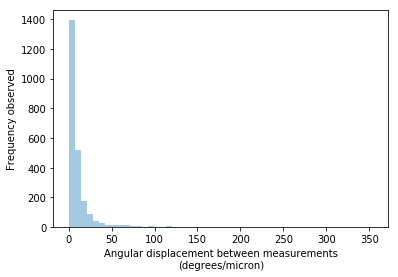

In [13]:
display(twist_df.loc[twist_df['diff_per_micron'].abs() == twist_df['diff_per_micron'].abs().max()])

fig, ax = plt.subplots(1)
ax = sns.distplot(twist_df['diff_per_micron'].abs().dropna(), kde=False)
ax.set_xlabel('Angular displacement between measurements\n(degrees/micron)')
ax.set_ylabel('Frequency observed')

In [14]:
# fig, ax = plt.subplots(15, 2, figsize=[25, 80], sharey=True)
# axes = ax.flatten()
# i = 0
# for om, rows in twist_df.groupby('om'):
#     rows = rows.loc[[i for i, v in rows['subtype'].items() if int(v[1]) < 7]] 
#     #display(rows)
#     sns.lineplot(x='z-index', y='cosine_sq', hue='subtype', data=rows, markers=True, ax=axes[i])
#     axes[i].set_title(f"Ommatidium: {om}")
#     i += 1
    
# axes[-1].remove()
# #fig.savefig("/mnt/home/nchua/Dropbox/200902_microvilli_raw_svf.pdf", bbox_inches='tight')

In [56]:
cols = pd.MultiIndex.from_product([['mean_diff', 'mean_diff_per_micron', 'SD_diff', 'mean_cosine_sq', 'r_mean_cosine_sq', 'SD_cosine_sq', 'max_displacement', 'SD_displacement', 'length', 'n_measure'], subtypes], names=['measure', 'subtype'])
twist_results = pd.DataFrame(columns = cols, index=all_om)

rh_length = pd.Series(index=all_om, dtype=float)

display(twist_df.loc[[bool([twist_df['om'] == 'A1']) & bool([twist_df['subtype'] == 'R7'])], 'cosine_sq'].mean())

for this_st, st_rows in twist_df.groupby('subtype'):
    for this_om, rows in st_rows.groupby('om'):
        # TODO: get rid of first difference when calculating mean? 
        
        #twist_results.loc[this_om, ('length', this_st)] = (rows['z-index'].max() - rows['z-index'].min()) * 8.0 /1000.0 # 1 px = 8/1000 microns
        
        twist_results.loc[this_om, ('mean_diff', this_st)] = rows['diff'].mean()
        twist_results.loc[this_om, ('SD_diff', this_st)] = rows['diff'].std()
        twist_results.loc[this_om, ('mean_diff_per_micron', this_st)] =  rows['diff_per_micron'].mean()
        
        twist_results.loc[this_om, ('mean_cosine_sq', this_st)] = rows['cosine_sq'].mean()
        
        twist_results.loc[this_om, ('SD_cosine_sq', this_st)] = rows['cosine_sq'].std()
        
        twist_results.loc[this_om, ('max_displacement', this_st)] = rows['cumulative'].max()
        twist_results.loc[this_om, ('SD_displacement', this_st)] = rows['cumulative'].std()
        #twist_results.loc[this_om, ('max_displacement_per_micron', this_st)] = rows['cumulative'].max() / twist_results.loc[this_om, ('length', this_st)]
        

#twist_results.loc[:, ('r_mean_cosine_sq')] = twist_results.loc[:, ('mean_cosine_sq', 'R7')] + 
#twist_results.loc[:, 'mean_cosine_sq']
#- twist_results.loc[:, ('mean_cosine_sq', 'R7')]
#display(twist_results.loc[:, ('mean_cosine_sq', 'R7')])
#display(twist_results.loc[:, ['mean_cosine_sq', 'r_mean_cosine_sq']])
# display(twist_results['length'])
# display(twist_results['mean_diff_per_micron'])

0.2606540710296966

measure mean_cosine_sq                                               \
subtype             R1         R2         R3          R4         R5   
A0            0.918955   0.718394   0.250798    0.893335   0.741273   
A1            0.903713   0.719712    0.29613    0.690571   0.352625   
A2            0.993766   0.768587   0.258918    0.851553   0.576765   
A3            0.971879   0.828762   0.281589    0.854627   0.504278   
A4            0.874632   0.109646   0.158864    0.897506   0.302756   
A5            0.995243  0.0560966  0.0325344    0.968693  0.0478263   
B0             0.90387   0.457855   0.136825    0.930235   0.756989   
B1            0.960076   0.450118  0.0951121    0.944914   0.682002   
B2            0.376643   0.173681   0.784345    0.389941   0.459853   
B3            0.880501   0.541913   0.518525    0.933681   0.583469   
B4            0.891602   0.614368   0.225364    0.750487   0.468734   
B5          0.00559298   0.962404   0.957923   0.0116179   0.963496   
B6            0.291616   0.843985    0.84866   0.0698122   0.967907   
C1            0.866757   0.612989   0.402246    0.677067   0.479053   
C2            0.386056   0.452065     0.8993    0.325533   0.411166   
C3            0.485047   0.641887   0.729555    0.364262   0.327773   
C4            0.773713   0.834533   0.038479    0.994148   0.719054   
C5            0.965391   0.233255   0.312687    0.861157   0.073995   
C6            0.168959   0.163069   0.131853    0.869653   0.246747   
D2            0.934487   0.847726   0.127765    0.925776   0.715114   
D3            0.144132  0.0975258   0.818054    0.425077    0.32264   
D4            0.928505   0.678223   0.365649    0.796904   0.588075   
D5             0.98958   0.825261    0.42241    0.913488    0.60928   
D6           0.0594153    0.97457   0.977908  0.00707258   0.978199   
D7            0.519027   0.942908   0.958128   0.0449764   0.973895   
E4            0.852453   0.919138   0.872332    0.785067   0.880184   
E5            0.932565   0.704947   0.339934    0.779483   0.251282   
E6            0.914172    0.43445   0.464498    0.546538   0.119752   
E7             0.57114   0.739945    0.76919    0.171616   0.747894   

measure                                            r_mean_cosine_sq            \
subtype         R6        R7        R7'         R8               R1        R2   
A0       0.0484928  0.470981   0.381149   0.809716         0.658301   0.45774   
A1       0.0166331   0.30606   0.850816   0.952426         0.643059  0.459058   
A2       0.0192615  0.414888   0.791043    0.76146         0.733112  0.507933   
A3         0.25525  0.793634   0.675536   0.830501         0.711225  0.568108   
A4        0.113918  0.803158   0.317026   0.363545         0.613978  0.848992   
A5        0.169533  0.851598  0.0647832   0.662196         0.734589  0.795442   
B0       0.0834359  0.991369   0.399895   0.521079         0.643216  0.197201   
B1       0.0461159  0.451163   0.615532   0.735772         0.699422  0.189464   
B2        0.950974    0.9613   0.593601   0.619698         0.115989  0.913027   
B3        0.132947  0.479477    0.72294   0.645569         0.619847  0.281259   
B4       0.0860193  0.518133   0.652843   0.454368         0.630948  0.353714   
B5        0.973474  0.980771  0.0176606  0.0181077         0.744939   0.70175   
B6        0.972929  0.976024  0.0706434  0.0712117        0.0309619  0.583331   
C1        0.412236  0.531323   0.778496   0.850886         0.606103  0.352335   
C2        0.878252  0.914644   0.710472   0.685914         0.125402  0.191411   
C3        0.924029  0.940712   0.687783   0.726351         0.224393  0.381233   
C4        0.203498  0.589522   0.621801   0.266706         0.513059  0.573879   
C5       0.0601228  0.983595   0.577285   0.994443         0.704737  0.972601   
C6        0.233201  0.670082   0.906603   0.785928         0.908305  0.902415   
D2       0.0334428  0.485173   0.667834    0.62862         0.673833  0.587072   
D3        0.9508

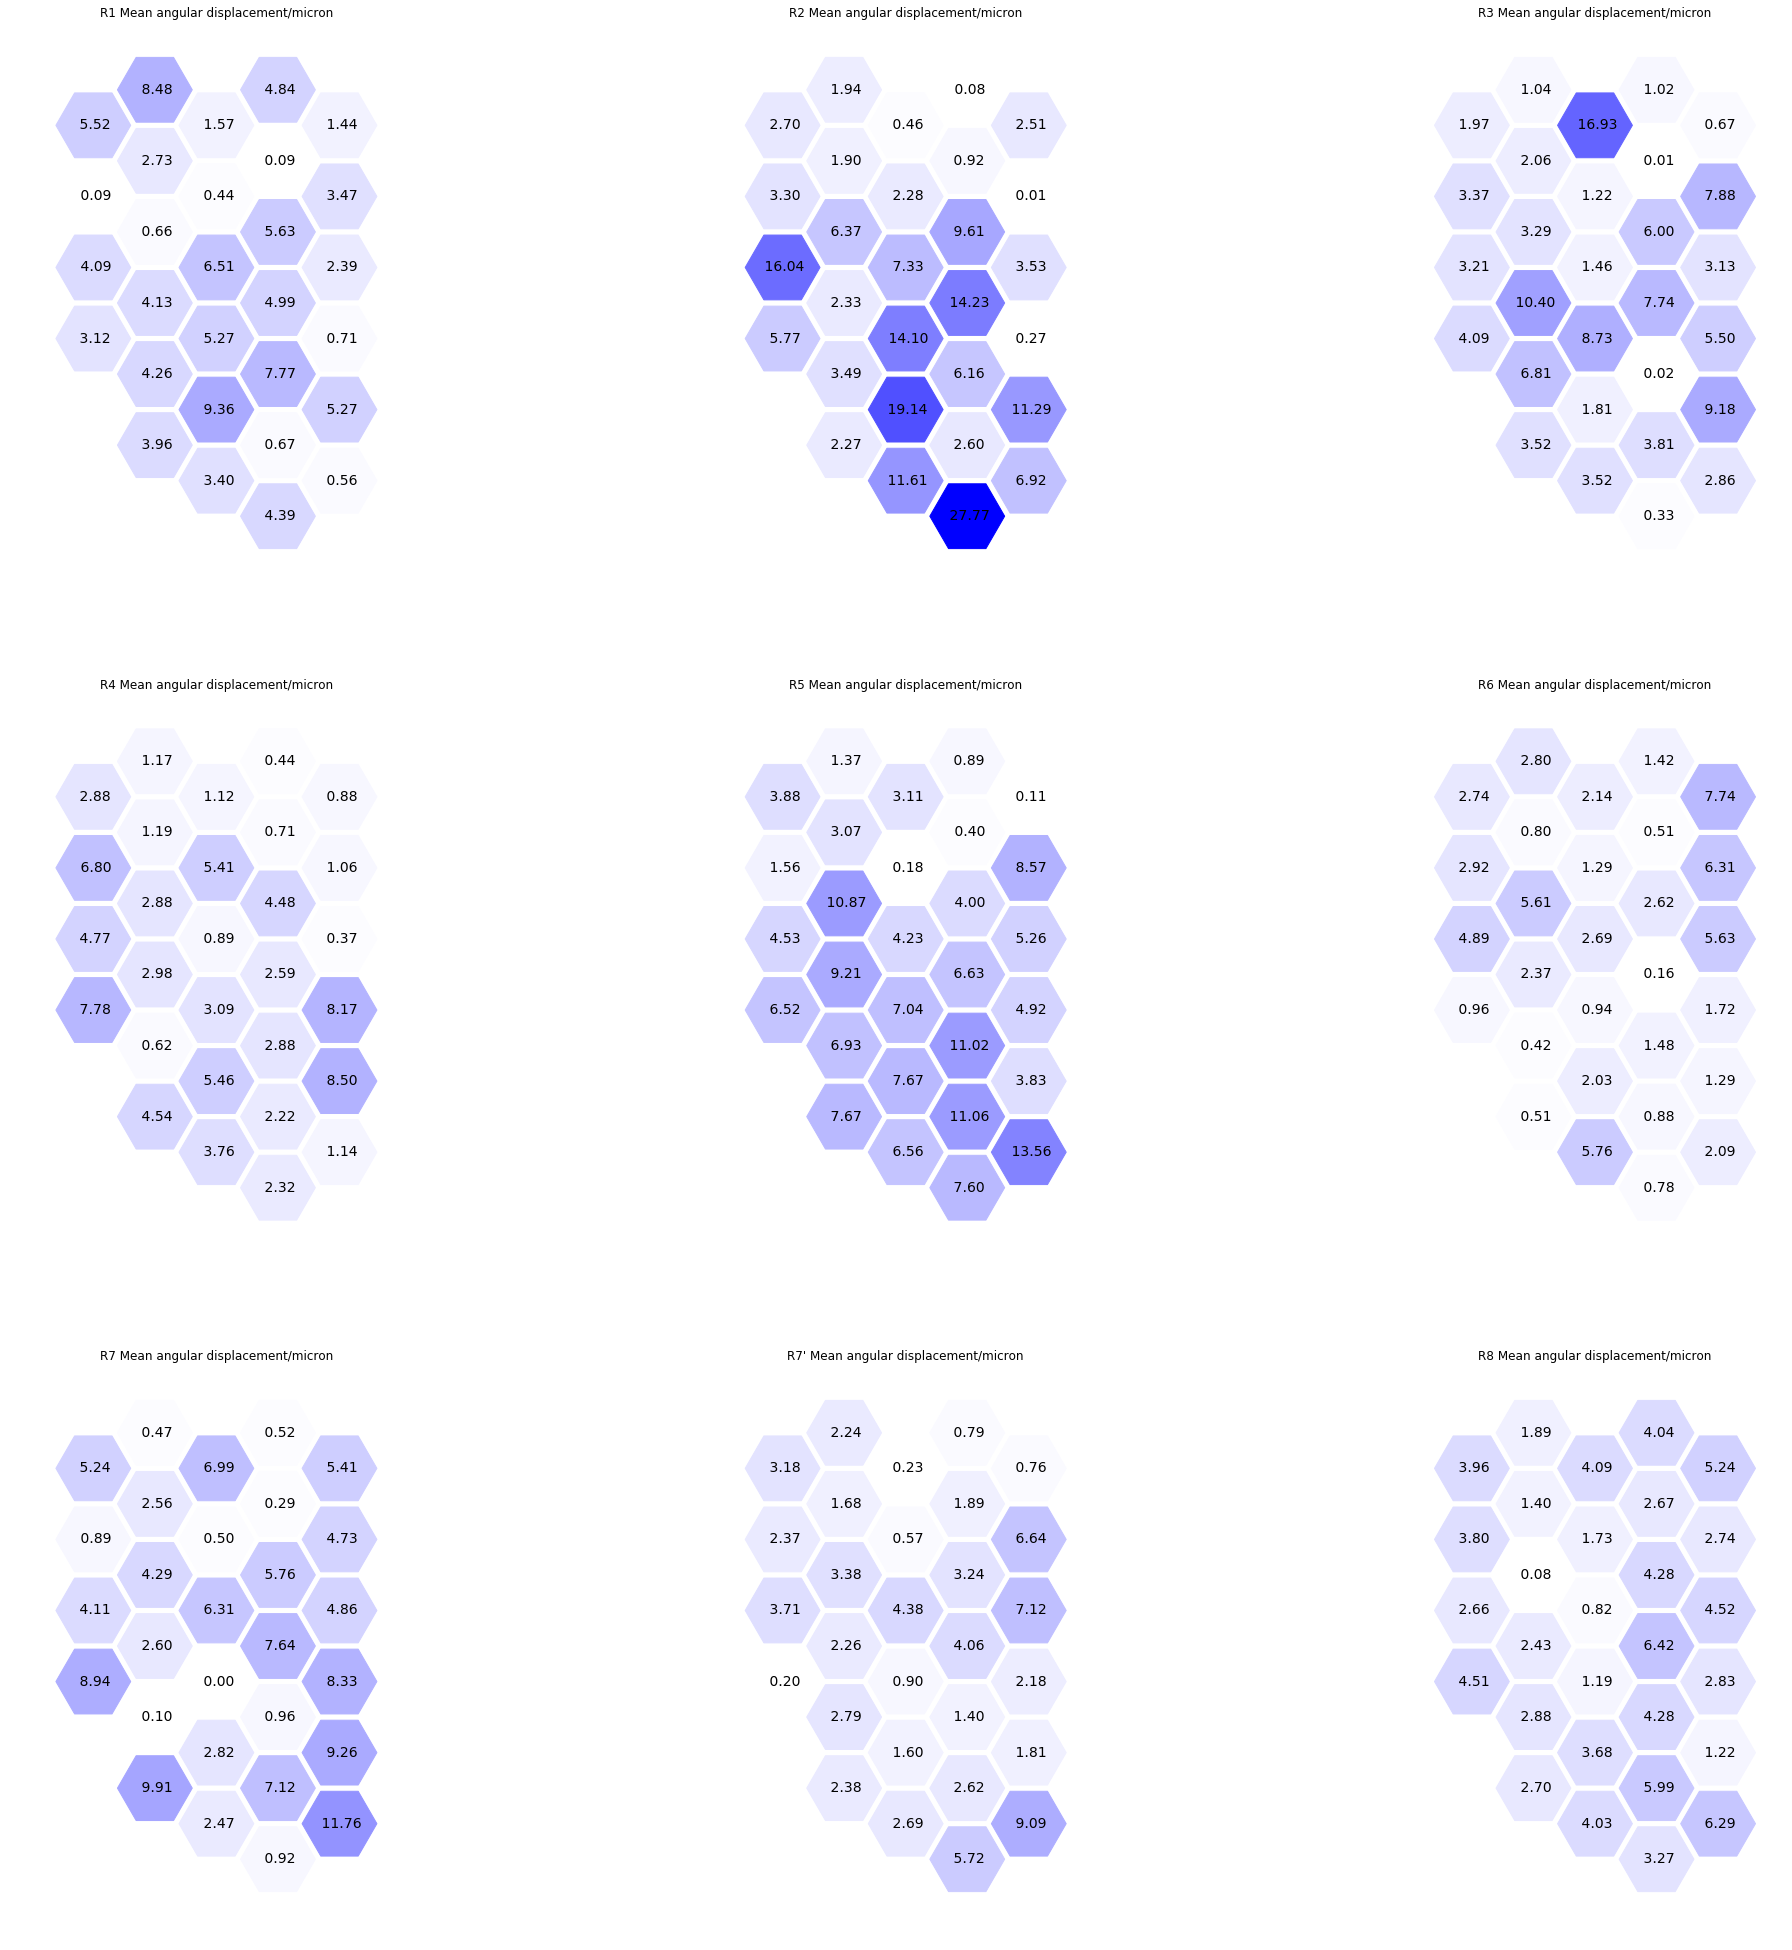

In [16]:
fig, axes = plt.subplots(3, 3, figsize=[35, 35])
# cm = linear_cmap(n_vals=100, max_colour=(1.0, 1.0, 1.0), min_colour='r')
cm = linear_cmap(n_vals=100, max_colour='b')
overall_max = abs(twist_results.loc[:, 'mean_diff']).max().max()

for ax, this_st in zip(axes.flatten(), subtypes):
    node_data = dict.fromkeys(all_om)
    this_max = abs(twist_results.loc[:, ('mean_diff', this_st)]).max()
    for om in all_om:
        x = abs(twist_results.loc[om, ('mean_diff', this_st)])
        node_data[om] = {'label': f"{x: .2f}",
                        'colour': cm(x/overall_max)}
    ax.set_title(f"{this_st} Mean angular displacement/micron")
    hexplot(node_data=node_data, ax=ax)

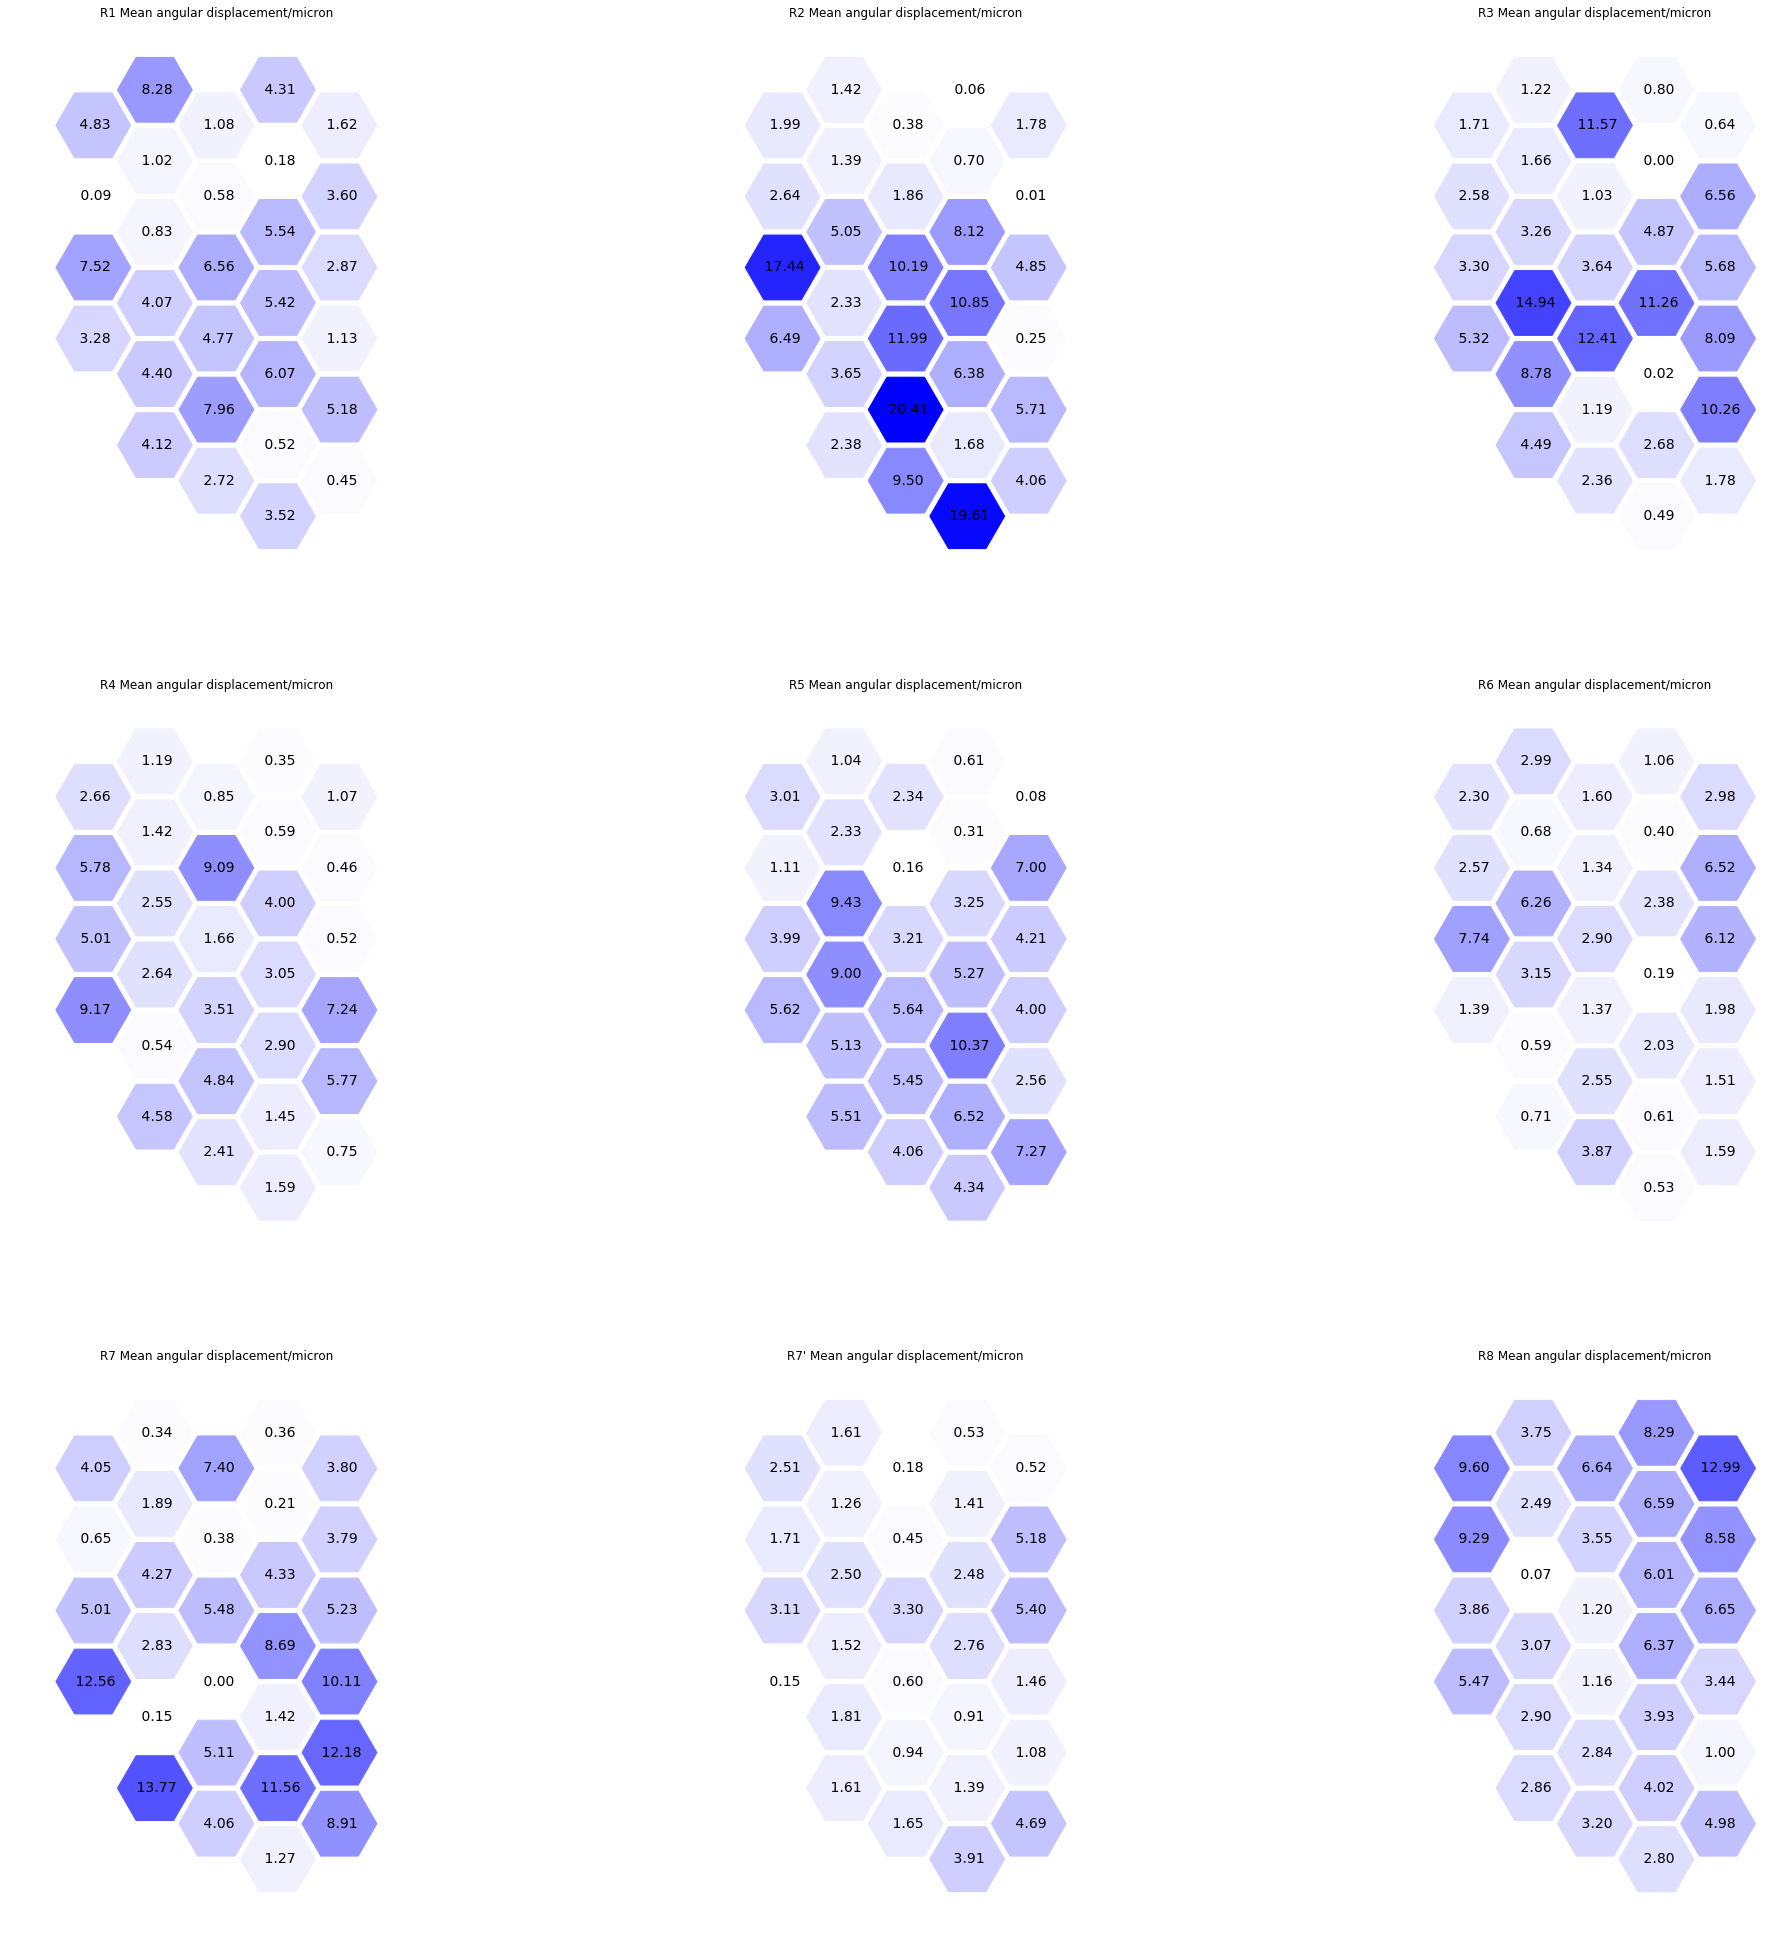

In [17]:
fig, axes = plt.subplots(3, 3, figsize=[35, 35])
# cm = linear_cmap(n_vals=100, max_colour=(1.0, 1.0, 1.0), min_colour='r')
cm = linear_cmap(n_vals=100, max_colour='b')
overall_max = abs(twist_results.loc[:, 'mean_diff_per_micron']).max().max()

for ax, this_st in zip(axes.flatten(), subtypes):
    node_data = dict.fromkeys(all_om)
    this_max = abs(twist_results.loc[:, ('mean_diff_per_micron', this_st)]).max()
    for om in all_om:
        x = abs(twist_results.loc[om, ('mean_diff_per_micron', this_st)])
        node_data[om] = {'label': f"{x: .2f}",
                        'colour': cm(x/overall_max)}
    ax.set_title(f"{this_st} Mean angular displacement/micron")
    hexplot(node_data=node_data, ax=ax)

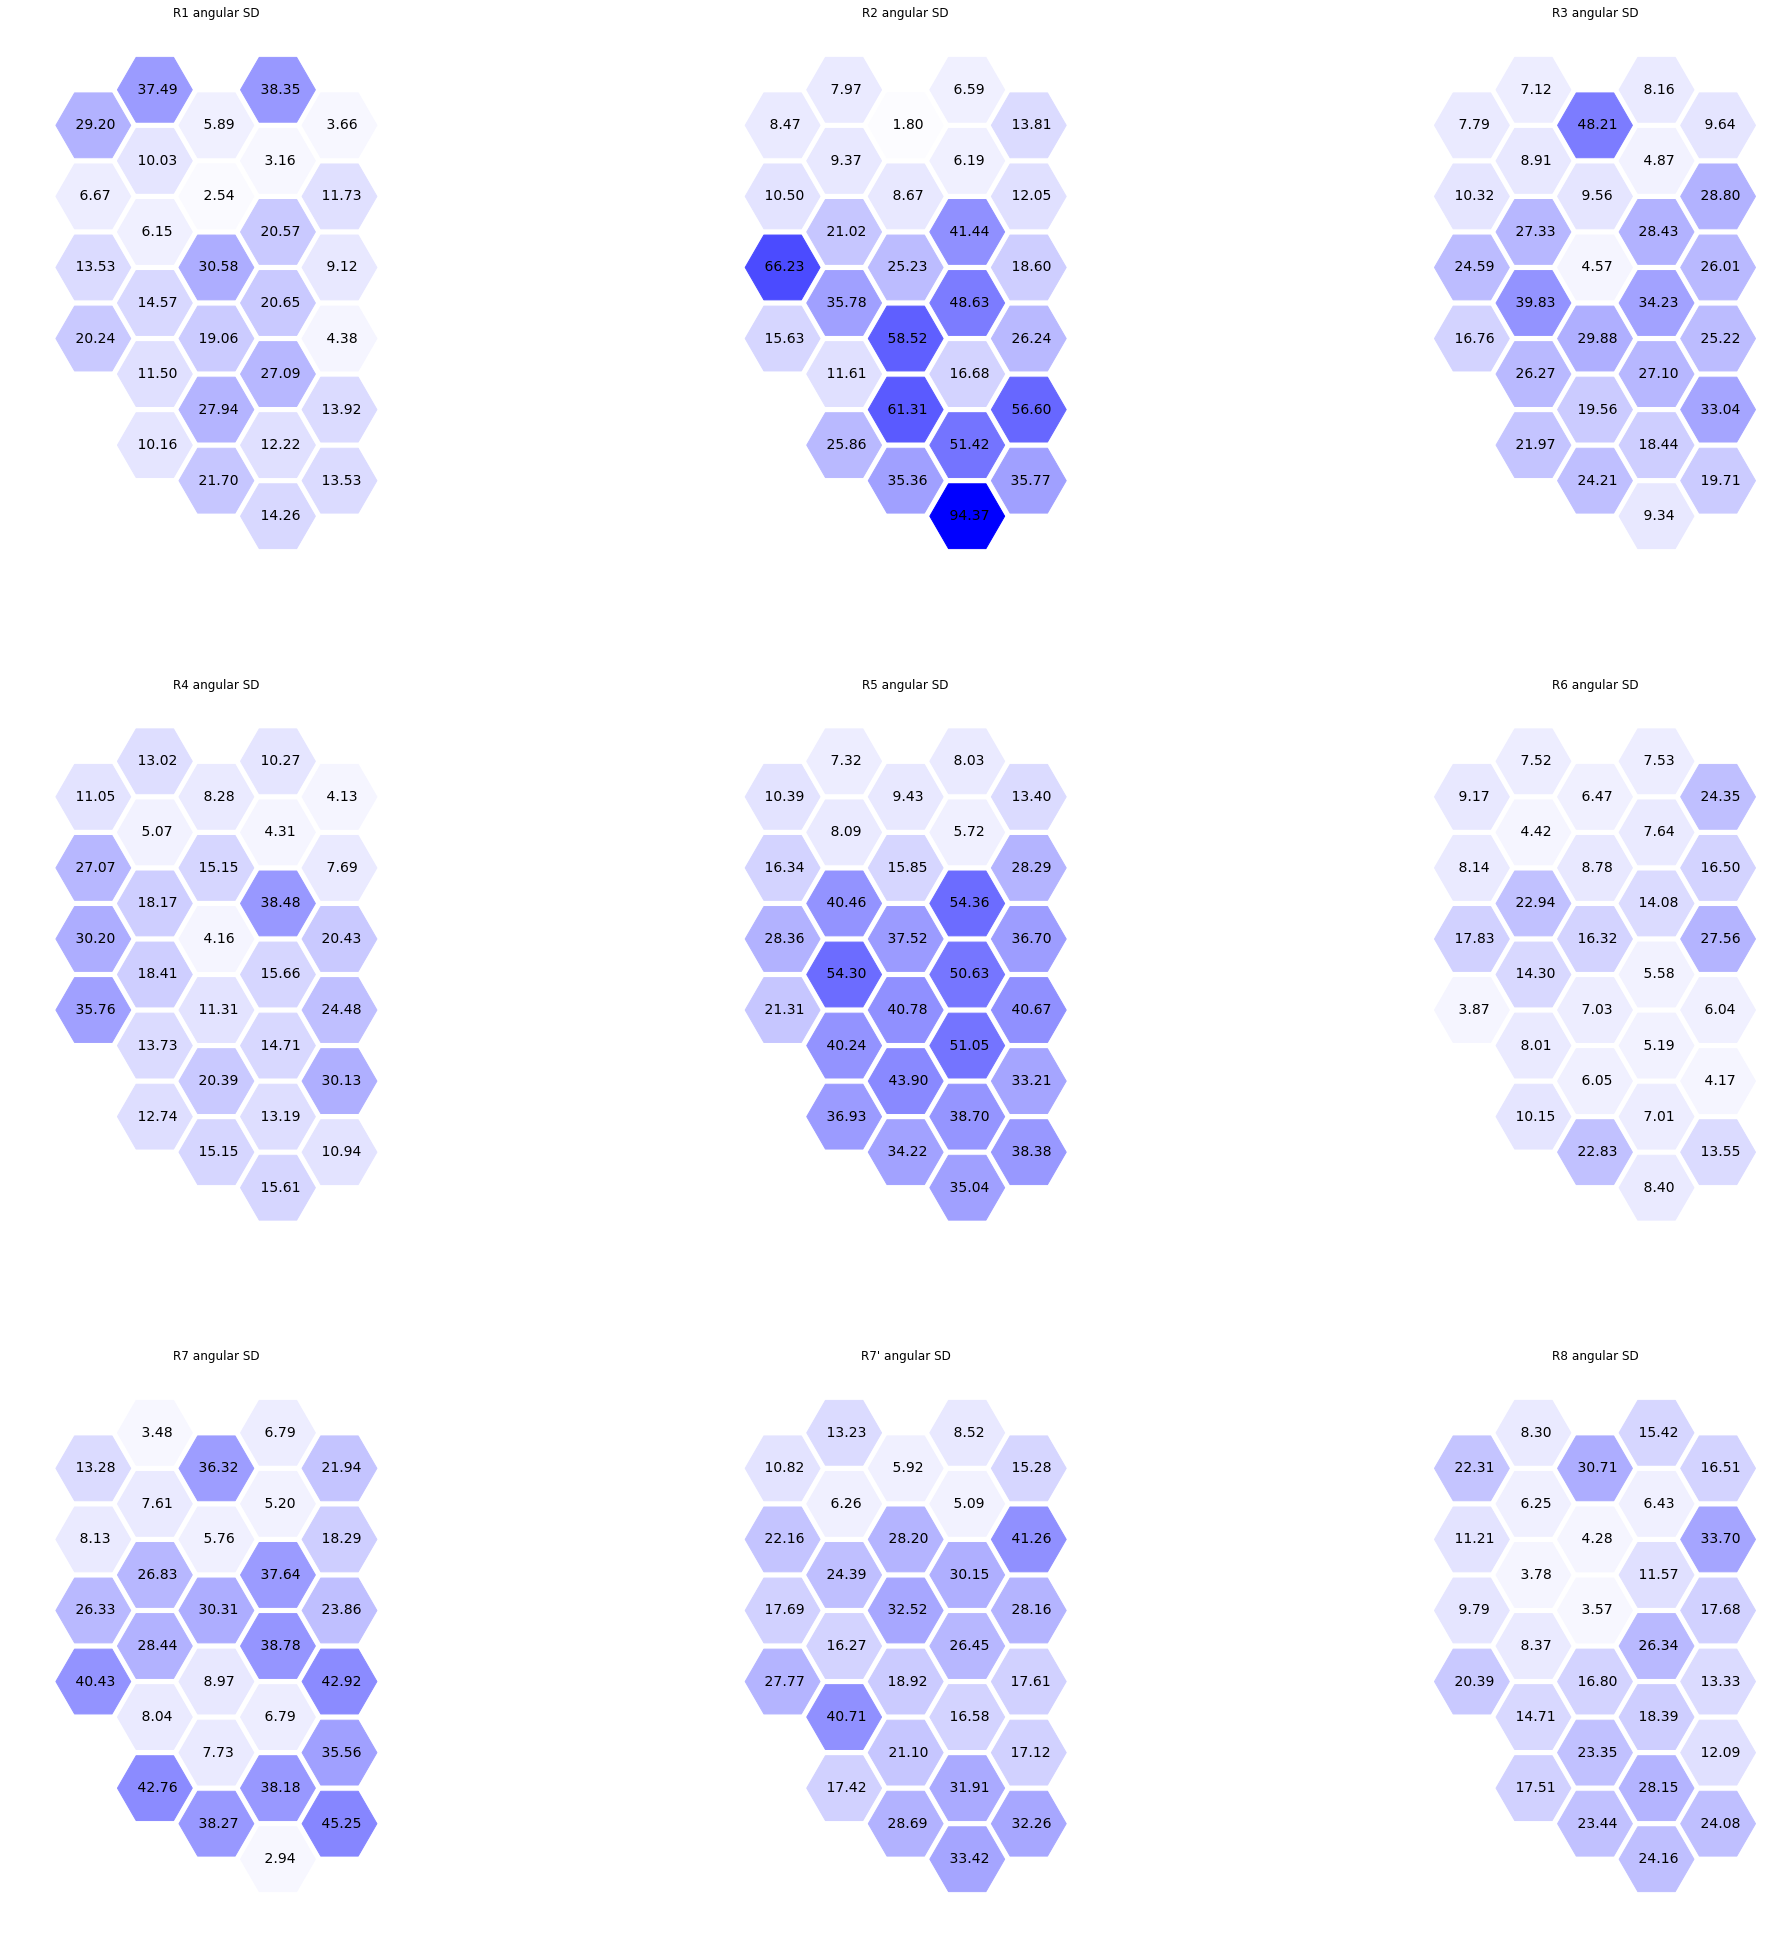

In [18]:
fig, axes = plt.subplots(3, 3, figsize=[35, 35])
# cm = linear_cmap(n_vals=100, max_colour=(1.0, 1.0, 1.0), min_colour='r')
cm = linear_cmap(n_vals=100, max_colour='b')
overall_max = abs(twist_results.loc[:, 'SD_displacement']).max().max()

for ax, this_st in zip(axes.flatten(), subtypes):
    node_data = dict.fromkeys(all_om)
    this_max = abs(twist_results.loc[:, ('SD_displacement', this_st)]).max()
    for om in all_om:
        x = abs(twist_results.loc[om, ('SD_displacement', this_st)])
        node_data[om] = {'label': f"{x: .2f}",
                        'colour': cm(x/overall_max)}
    ax.set_title(f"{this_st} angular SD")
    hexplot(node_data=node_data, ax=ax)

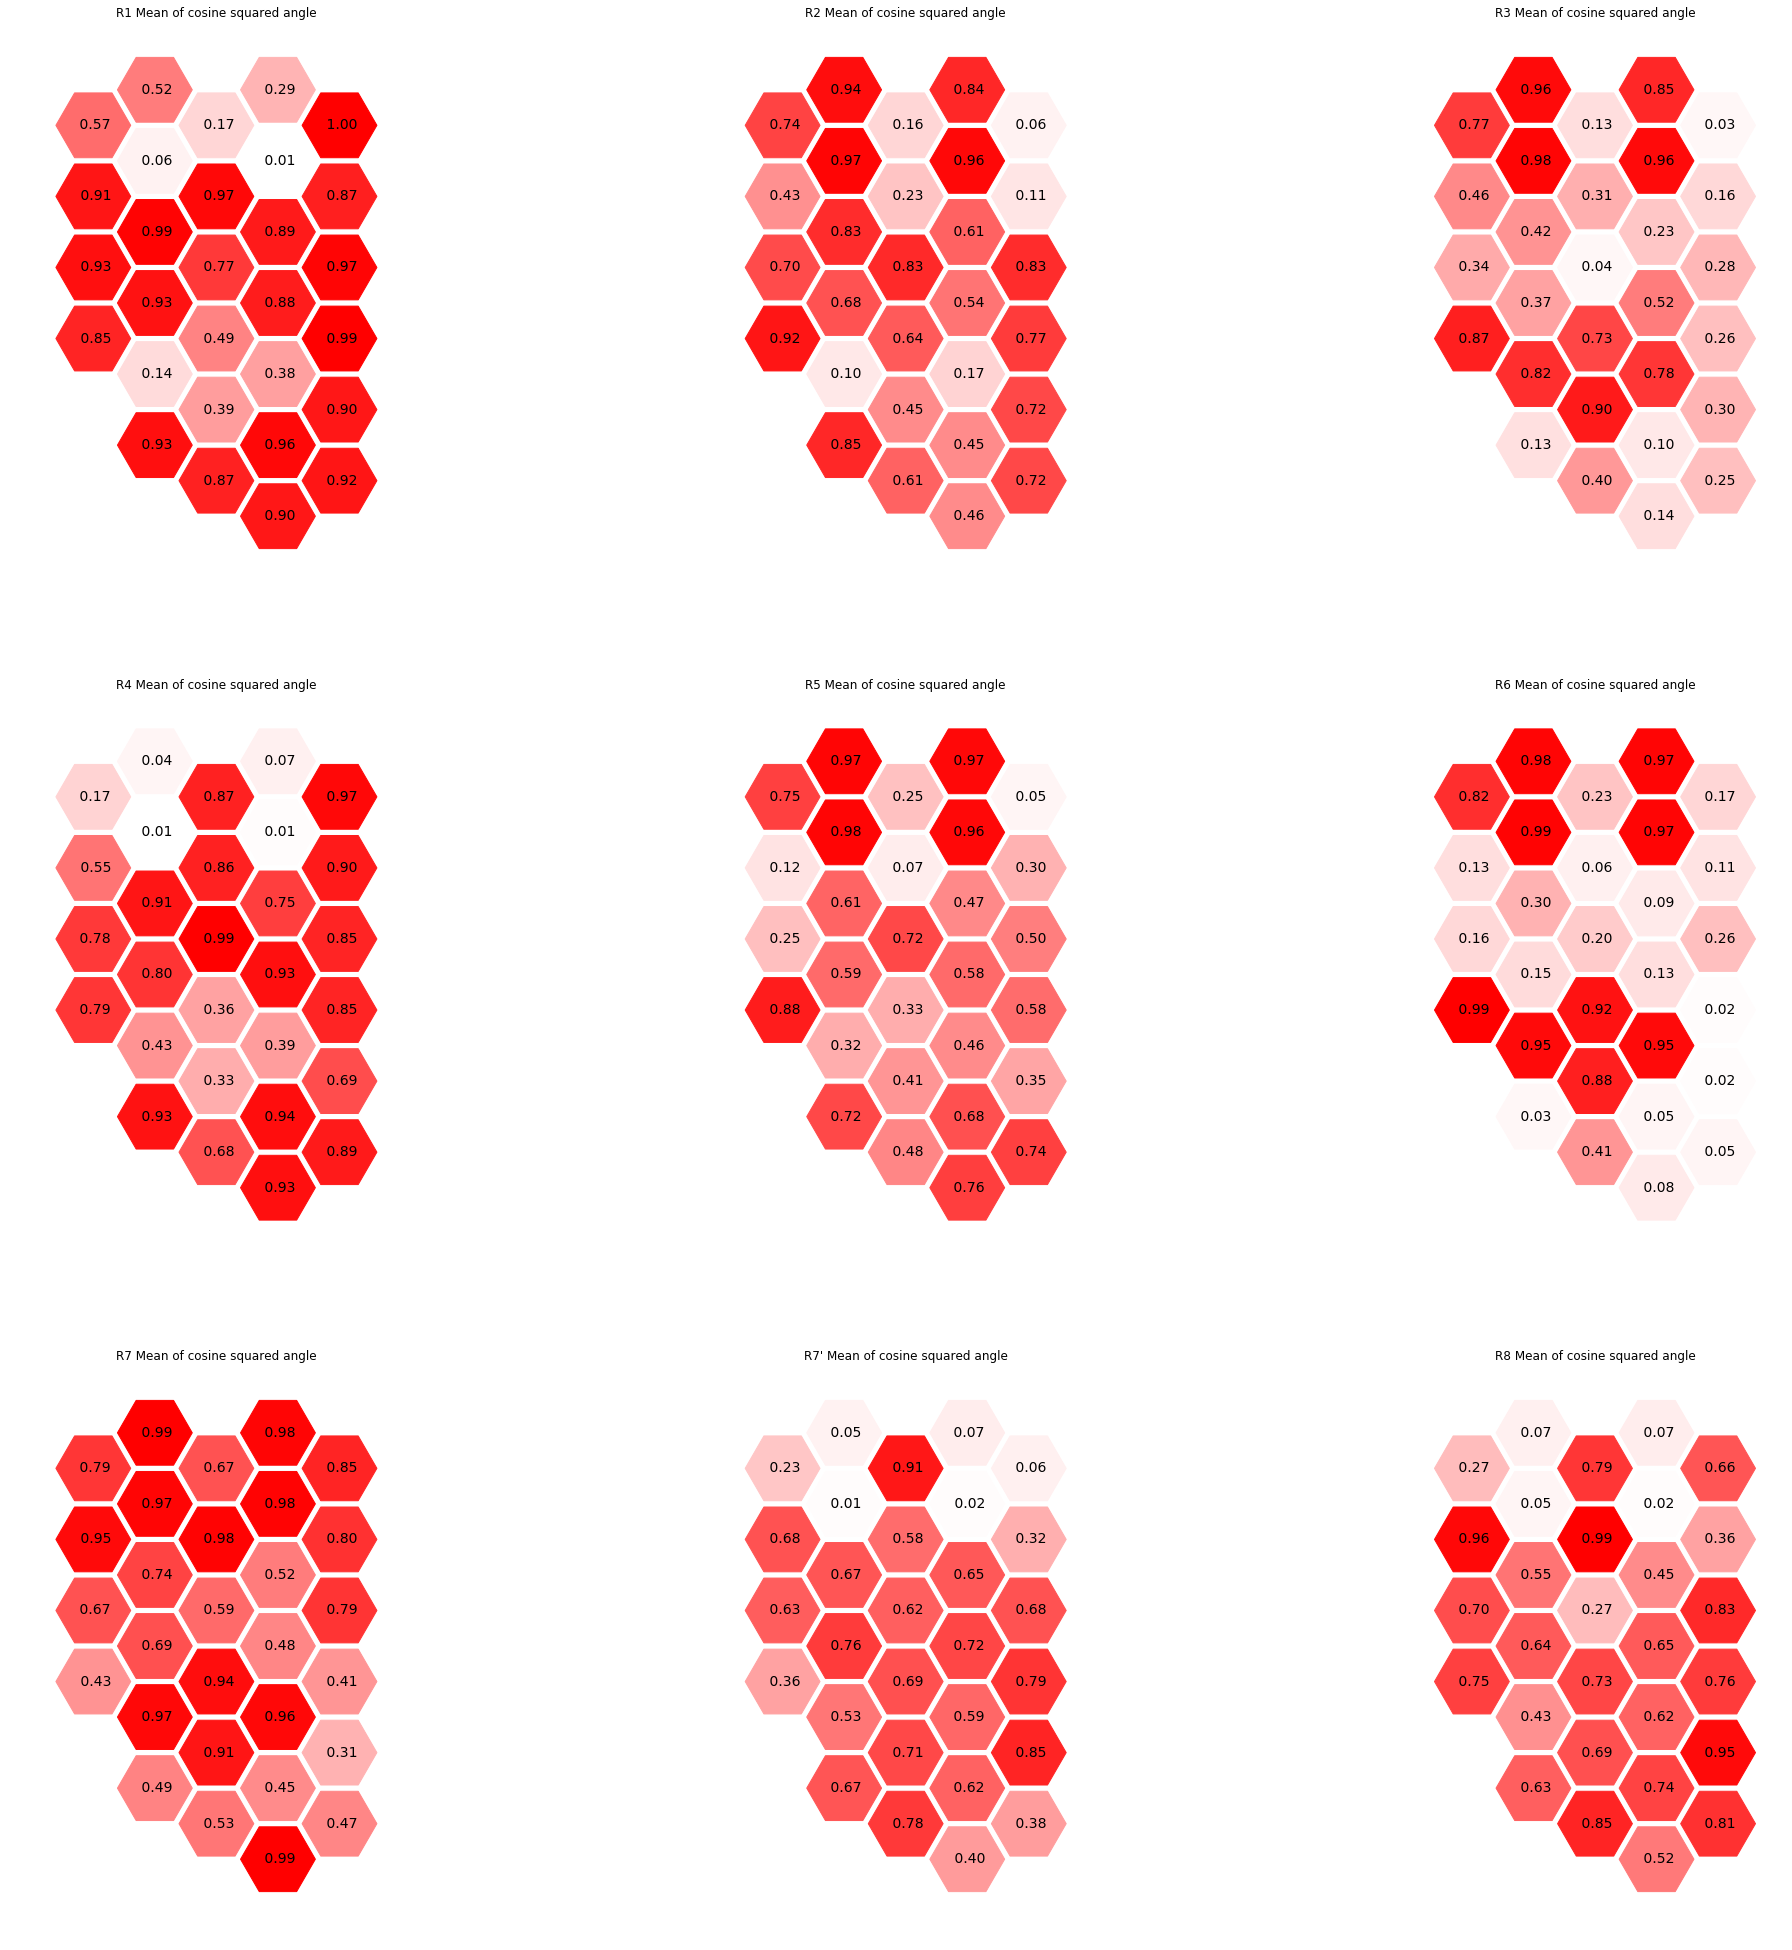

In [19]:


fig, axes = plt.subplots(3, 3, figsize=[35, 35])
# cm = linear_cmap(n_vals=100, max_colour=(1.0, 1.0, 1.0), min_colour='r')
cm = linear_cmap(n_vals=100, max_colour='r')

for ax, this_st in zip(axes.flatten(), subtypes):
    node_data = dict.fromkeys(all_om)
    this_max = twist_results.loc[:, ('mean_cosine_sq', this_st)].max()
    for om in all_om:
        data = twist_results.loc[om, ('mean_cosine_sq', this_st)]
        node_data[om] = {'label': f"{data: .2f}",
                        'colour': cm(data)}
    ax.set_title(f"{this_st} Mean of cosine squared angle")
    hexplot(node_data=node_data, ax=ax)

In [20]:
s, p, = mannwhitneyu(r7_sd[dra_om], r7_sd[ndra_om], alternative='less')
print("###### RESULTS ######")
print(f"Test statistic: {s}, p-value: {p: .6f}")
if p > 0.01:
    print("Fail to reject null")
else:
    print("Reject null: DRA R7 receive more inputs")

NameError: name 'r7_sd' is not defined

In [ ]:
s, p, = mannwhitneyu(r7p_sd[dra_om], r7p_sd[ndra_om], alternative='less')
print("###### RESULTS ######")
print(f"Test statistic: {s}, p-value: {p: .6f}")
if p > 0.01:
    print("Fail to reject null")
else:
    print("Reject null: DRA R7 receive more inputs")